# Building an NBA Position Classifier 
### Module 3 Project Submission


* Student name: Jeremy Lee
* Student pace: Part Time
* Scheduled project review date/time: Nov 19, 2020 @ 2:30 PM 
* Instructor name: Amber Yandow


# Introduction

Over the 74 year history of the NBA, it has undergone a number of evolutions.  The 24 second shot clock was implemented in beginning in 1954. The key was widened from 6 feet to 12 feet in 1951 and widened again to 16 feet in 1964. The three point line was first used in the 1979-1980 NBA season. For the past few years, much of the conversation surrounding the NBA and its players has been the rise of 'small-ball'. Small ball can be generally described as a play style that emphasizes a faster pace of play, increased three point shooting, and a lineup consisting of four perimeter players (e.g. some combination of point guards, shooting, guards, or small forwards) and one big (e.g. either a power forward or center). Regardless of the rules used to govern the game and the geometry of the court, the game must be played with 5 players for each team and each of those players must play with a specific role and purpose in order for their team to win. 

With the understanding that across all eras of basketball, there are differences in styles of play and roles for each of the 5 positions on the court, we can use a combination of basketball statistics to create a classifier model that will predict a player's position for a given season.

## Business Understanding

### Why build a position classifier model?
With a basic definition for each of the 5 basketball positions (Point Guard - PG, Shooting Guard - SG, 
Small Forward - SF, Power Forward - PF, Center - C) and some game film, it would stand to reason that an individual with limited basketball knowledge could learn to identify the different positions. Certainly those individuals in a professional basketball organization could identify the positions for a variety of different lineups without any trouble at all.  

So why build an NBA position classifier and how would it be useful?

Building a classifier can tell us more than just the position of a player. We would certainly expect that a well tuned model could tell us the position of a player just as we might identify those positions while watching a game. In addition to the model telling us the position we can get the *probabilities* that a player plays at each position. The probabilities can be very useful for the decision makers in an NBA franchise. 

Consider this example: A starting point guard (Player A) plays on a bad team and becomes a free agent at the end of the season. A playoff that fell short of winning it all needs to replace their starting shooting guard (Player B) after that player decided to abruptly retire.  With the position classifier, the front office of the playoff team can see that Player A is 45% point guard, 40% shooting guard, 10% small forward, 3% power forward, and 2% center. Given that this team still has championship aspirations they are apprehensive to start their rookie drafted in the second round. Instead they sign Player A to a contract and have Player A as the starting shooting guard for their team. With the knowledge that Player A can also play the point guard position, the coach of the playoff team can also create lineups where Player A can step in as point guard if the regular starting guard is out for rest or injury.

The position classifier can help inform decisions based around free agency or trades and allow for lineup analysis within the team organization which is very valuable.  Given that decision makers cannot watch every player in every game it is necessary to have a model that can provide quick and efficient analysis of hundreds of players across the league.  It is important to note that the model should be used a tool to *assist* with decision making.  There are many subtle nuances in the game of basketball that cannot be picked up by statistics or cannot be measured.  It should very much be used in conjunction with other information so that you can draw an informed conclusion.  

A well tuned position classifier also has the potential to do the following:
 - Position analysis for NBA Draft prospects given that certain players may have to learn to play a new position in the NBA
 - Offer statistical method to evaluate players for end-of-year season awards. Media members vote for end of season awards and those votes will always be subject to bias. The current structure of the All NBA awards require each All NBA team to have two guards, two forwards, and a center. If we can understand the probabilities of each position associated with a player then we can better compare players when voting for these teams and hopefully create the fairest teams. All NBA selections can affect the value of player contracts so eliminating bias by using a model has huge implications.

In this analysis we will ask the following questions:
1. What the most important features in determining a position?
2. What positions are the most difficult to classify and which positions are hybrids?
3. What does the model tell us about a starting lineup for a championship team? Are there commonalities amongst the position breakdown for a championship starting lineup?

We will also look at trends across positions in various seasons for different player statistics. 

Let's first import the necessary libraries we need for our analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.style as style
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.express as px

The data we will be using has been collected from [basketball-reference.com](https://www.basketball-reference.com/) and [stats.nba.com](https://www.nba.com/stats/) via the NBA Stats Tracking module that can be found [here](https://nba-stats-tracking.readthedocs.io/en/latest/source/quickstart.html). We will be looking at stats from the 2015-2016 season to the 2018-2019 season. The data collection process that used to create the below dataframe can be found in the Jupyter notebook titled `data_collection.ipynb`.

In [2]:
df = pd.read_csv('nba_complete_2015-2019.csv')
pd.set_option('max_columns', None) #set dataframe to view all columns
df.head(20)

,PLAYER_NAME,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,two_pt_fg_pct,three_pt_fg_pct,DRIVES,DRIVE_FGM,DRIVE_FGA,DRIVE_PASSES,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,TOUCHES,FRONT_CT_TOUCHES,TIME_OF_POSS,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG3M,PULL_UP_FG3A,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF
0,Quincy Acy (15-16),PF,25,SAC,59,29,876,6.5,11.7,0.556,1.0,2.7,0.388,5.5,9.0,0.606,2.7,3.7,0.735,3.6,6.7,10.3,1.5,1.6,1.3,1.5,5.6,16.8,124.0,108,14.7,0.629,0.229,0.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,0.137,-0.2,0.2,-0.1,0.4,0.771,0.229,0.606,0.388,26,7,12,9,32,79,16.0,46.0,1116,602,23.3,5,10,2.0,2.0,62.4,32.3,30.1
1,Jordan Adams (15-16),SG,21,MEM,2,0,15,6.9,20.6,0.333,0.0,3.4,0.000,6.9,17.2,0.400,10.3,17.2,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,6.9,24.0,84.0,90,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,0.015,-2.5,9.4,6.9,0.0,0.833,0.167,0.400,0.000,1,0,0,1,0,1,0.0,1.0,22,12,0.8,1,3,0.0,0.0,1.2,0.6,0.5
2,Steven Adams (15-16),C,22,OKC,80,80,2014,6.4,10.5,0.613,0.0,0.0,NaN,6.4,10.5,0.613,2.8,4.8,0.582,5.4,7.7,13.1,1.5,1.0,2.2,2.1,5.5,15.7,123.0,105,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,0.155,0.0,0.2,0.2,1.1,1.000,0.000,0.613,NaN,14,1,7,5,4,10,NaN,NaN,3601,1421,81.9,0,2,NaN,NaN,143.0,77.2,65.8
3,Arron Afflalo (15-16),SG,30,NYK,71,57,2371,7.7,17.3,0.443,2.0,5.2,0.382,5.7,12.2,0.469,2.4,2.8,0.840,0.5,5.3,5.8,3.1,0.5,0.2,1.8,3.1,19.7,105.0,112,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,0.055,-1.3,-1.6,-2.9,-0.5,0.702,0.298,0.469,0.382,224,44,106,68,123,299,76.0,196.0,3744,2749,157.5,132,292,12.0,37.0,165.9,92.4,73.5
4,Alexis Ajinca (15-16),C,27,NOP,59,17,861,8.6,18.1,0.476,0.0,0.1,0.000,8.6,18.1,0.478,3.0,3.6,0.839,4.3,11.2,15.5,1.8,1.1,2.1,3.1,7.7,20.3,100.0,107,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,0.058,-3.4,-0.6,-4.0,-0.4,0.997,0.003,0.478,0.000,27,7,19,4,51,122,0.0,1.0,1485,773,34.7,10,21,0.0,0.0,58.3,30.4,27.9
5,Cole Aldrich (15-16),C,27,LAC,60,5,800,8.4,14.1,0.596,0.0,0.0,NaN,8.4,14.1,0.596,3.8,5.3,0.714,5.4,12.7,18.0,3.1,2.9,4.3,4.0,8.7,20.5,113.0,94,21.3,0.626,0.000,0.373,11.9,27.1,19.6,10.0,2.9,6.7,19.6,18.4,1.4,2.0,3.5,0.209,-0.9,3.4,2.4,0.9,1.000,0.000,0.596,NaN,7,1,3,3,0,0,NaN,NaN,1604,817,39.6,0,2,NaN,NaN,55.5,29.6,25.9
6,LaMarcus Aldridge (15-16),PF,30,SAS,74,74,2261,12.1,23.7,0.513,0.0,0.4,0.000,12.1,23.3,0.521,5.9,6.8,0.858,4.0,10.3,14.3,2.5,0.9,1.8,2.2,3.4,30.1,114.0,99,22.4,0.565,0.015,0.289,9.2,22.2,15.9,8.1,0.9,2.8,7.8,25.9,5.6,4.5,10.1,0.215,2.0,0.3,2.3,2.5,0.985,0.015,0.521,0.000,86,25,50,15,149,337,0.0,15.0,4126,2781,123.1,79,221,0.0,1.0,153.7,82.8,70.8
7,Cliff Alexander (15-16),PF,20,POR,8,0,36,6.9,13.9,0.500,0.0,0.0,NaN,6.9,13.9,0.500,0.0,0.0,NaN,2.8,5.6,8.3,0.0,1.4,2.8,1.4,1.4,13.9,100.0,107,11.6,0.500,0.000,0.000,6.0,12.1,9.0,0.0,1.4,4.4,9.1,13.3,0.0,0.0,0.0,0.052,-0.5,0.5,0.0,0.0,1.000,0.000,0.500,NaN,0,0,0,0,0,2,NaN,NaN,50,26,1.3,1,1,NaN,NaN,2.6,1.4,1.2
8,Lavoy Allen (15-16),PF,26,IND,79,28,1599,5.9,11.5,0.516,0.0,0.0,NaN,5.9,11.5,0.516,1.4,2.3,0.630,5.0,8.1,13.2,2.4,0.8,1.3,2.1,4.6,13.3,110.0,104,12.4,0.532,0.000,0.197,11.1,17.8,14.5,7.1,0.8,2.1,14.6,13.0,1.6,2.1,3.7,0.110,-1.7,0.1,-1.6,0.2,1.000,0.000,0.516,NaN,12,1,7,3,45,121,NaN,NaN,2603,1512,65.4,3,5,NaN,NaN,109.8,57.8,52.0
9,Tony Allen (15-16),SG,34,MEM,64,57,1620,6.8,14.9,0.458,0.5,1.3,0.357,6.4,13.6,0.468,2.9,4.4,0.652,3.3,6.1,9.4,2.2,3.5,0.6,2.5,5.6,17.0,101.0,105,12.9,0.505,0.090,0.294,7.0,14.1,10.4,6.9,3.5,1.0,12.8,16.8,0.5,1.9,2.4,0.072,-2.2,1.2,-1.0,0.4,0.910,0.090,0.468,0.357,194,34,93,56,30,84,15.0,42.0,1957,1346,79.0,13,34,0.0,0.0,112.2,58.4,53.7


# Cleaning Data

In [3]:
#Dropping redundant columns ('two_pt_fg_pct' and 'three_pt_fg_pct')
df = df.drop(columns = ['two_pt_fg_pct', 'three_pt_fg_pct', 'pct_of_FGA_twos', 'pct_of_FGA_threes'])

Fortunately both Basketball Reference and the NBA stats website are very comprehensive in the stats that they offer. It is also the case that the variables used for EDA and modeling are either integers or floats.  We will first check for null values.

In [4]:
pd.set_option('display.max_rows', None)
df.isna().sum() #check for null values 

PLAYER_NAME            0
Pos                    0
Age                    0
Tm                     0
G                      0
GS                     0
MP                     0
FG                     0
FGA                    0
FG%                    9
3P                     0
3PA                    0
3P%                  164
2P                     0
2PA                    0
2P%                   28
FT                     0
FTA                    0
FT%                   95
ORB                    0
DRB                    0
TRB                    0
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
PTS                    0
ORtg                   8
DRtg                   0
PER                    0
TS%                    9
3PAr                   9
FTr                    9
ORB%                   0
DRB%                   0
TRB%                   0
AST%                   0
STL%                   0
BLK%                   0


We will replace all null values with 0. Looking at the columns it seems that null values were created when
dividing by zero (i.e. 3PT%  = 3PTs made/ 3PTs attempted and a player with zero 3PT attempts will have zero 
which can be interepreted as 0%. Mathematically it would be 0/0, which is undefined. Hence there are some null values for certain variables.

We see that there is one player who has null values as for the distance metrics. It is likely this player
only played one game and was possibly substituted in at the end of a game just so that the game could be finished.

Nonetheless, we will also substitute the null values for this player with 0 and use conditions to filter out players who did not play in meaningful possessions.

In [6]:
df.fillna(0, inplace=True)

We will also do some math to transform the NBA tracking statistics from season aggregates to per game stats. The NBA tracking statistics start with the column labeled `DRIVES` as seen in the columns array below. It's much more intuitive to think about how many miles a player traveled on the court in a single game rather than over the course of a season.

For clarification, the columns `PLAYER_NAME` is column that has been formatted to include the player's name and the season in which they played. Columns from `Pos` to `DRtg` are Basketball Reference stats. An example can be found [here](https://www.basketball-reference.com/leagues/NBA_2018_per_poss.html).  Columns from `PER` to `VORP` are [advanced stats](https://www.basketball-reference.com/leagues/NBA_2018_advanced.html) found on Basketball Reference. The remaining columns are from stats.nba.com.

It's also important to note that the box score statistics from basketball reference are per 100 possessions. Per 100 possessions are typically better for analysis because it eliminates discrepancies in pace and style of play. 
Teams that play at a faster pace won't have a statistical advantage over teams that play slower. Also not all games are created equal - some games last for the regulation 48 minutes and others go into a single or multiple overtimes. If you would like to read more about why possessions are important for leveling the playing field check out this [article](https://www.nba.com/stats/articles/nba-com-stats-switches-to-true-possessions-what-it-means-and-why-its-important/). 

In [8]:
#check columns
df.columns

Index(['PLAYER_NAME', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'pct_of_FGA_twos', 'pct_of_FGA_threes', 'DRIVES',
       'DRIVE_FGM', 'DRIVE_FGA', 'DRIVE_PASSES', 'CATCH_SHOOT_FGM',
       'CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3M', 'CATCH_SHOOT_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'TIME_OF_POSS', 'PULL_UP_FGM', 'PULL_UP_FGA',
       'PULL_UP_FG3M', 'PULL_UP_FG3A', 'DIST_MILES', 'DIST_MILES_OFF',
       'DIST_MILES_DEF'],
      dtype='object')

Below are the calculations used to convert the season aggregates stats from the NBA website to per game stats.

In [9]:
df['MPG'] = df['MP']/df['G'] #calculate minutes per game

#calculate per game drive stats and drive field goal percentage 
df['DRIVES/GM'] = df['DRIVES']/df['G']
df['DRIVE_FGA/GM'] = df['DRIVE_FGA']/df['G']
df['DRIVE_FG%'] = df['DRIVE_FGM']/df['DRIVE_FGA']
df['DRIVE_PASSES/GM'] = df['DRIVE_PASSES']/df['G']

#calculate per game catch & shoot stats and catch & shoot percentage
df['CATCH_SHOOT%'] = df['CATCH_SHOOT_FGM']/df['CATCH_SHOOT_FGA']
df['CATCH_SHOOT_FGA/G'] = df['CATCH_SHOOT_FGA']/df['G']
df['CATCH_SHOOT_FG3%'] = df['CATCH_SHOOT_FG3M']/df['CATCH_SHOOT_FG3A']
df['CATCH_SHOOT_FG3A/GM'] = df['CATCH_SHOOT_FG3A']/df['G']

#calculate touches per game 
df['TOUCHES/GM'] = df['TOUCHES']/df['G']
df['FRONT_CT_TCH/GM'] = df['FRONT_CT_TOUCHES']/df['G']
df['TIME_OF_POSS/GM (min)'] = df['TIME_OF_POSS']/df['G']

#calculate per game pull up stats and pull up percentage
df['PULL_UP%'] = df['PULL_UP_FGM']/df['PULL_UP_FGA']
df['PULL_UP_FGA/GM'] = df['PULL_UP_FGA']/df['G']
df['PULL_UP_FG3%'] = df['PULL_UP_FG3M']/df['PULL_UP_FG3A']
df['PULL_UP_FG3A/GM'] = df['CATCH_SHOOT_FG3A']/df['G']

#calculate distance traveled per game
df['DIST_MILES/G'] = df['DIST_MILES']/df['G']
df['DIST_MILES_OFF/GM'] = df['DIST_MILES_OFF']/df['G']
df['DIST_MILES_DEF/GM'] = df['DIST_MILES_DEF']/df['G']



In [10]:
df.isna().sum()

PLAYER_NAME                0
Pos                        0
Age                        0
Tm                         0
G                          0
GS                         0
MP                         0
FG                         0
FGA                        0
FG%                        0
3P                         0
3PA                        0
3P%                        0
2P                         0
2PA                        0
2P%                        0
FT                         0
FTA                        0
FT%                        0
ORB                        0
DRB                        0
TRB                        0
AST                        0
STL                        0
BLK                        0
TOV                        0
PF                         0
PTS                        0
ORtg                       0
DRtg                       0
PER                        0
TS%                        0
3PAr                       0
FTr                        0
ORB%          

In [11]:
#Check to make sure there are 435 players who had zero 3 point pull up attempts
len(df.loc[df['PULL_UP_FG3A'] == 0])

435

In [12]:
df.fillna(0, inplace=True)

In [13]:
df.isna().sum()

PLAYER_NAME              0
Pos                      0
Age                      0
Tm                       0
G                        0
GS                       0
MP                       0
FG                       0
FGA                      0
FG%                      0
3P                       0
3PA                      0
3P%                      0
2P                       0
2PA                      0
2P%                      0
FT                       0
FTA                      0
FT%                      0
ORB                      0
DRB                      0
TRB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
PF                       0
PTS                      0
ORtg                     0
DRtg                     0
PER                      0
TS%                      0
3PAr                     0
FTr                      0
ORB%                     0
DRB%                     0
TRB%                     0
A

In [14]:
df.fillna(0, inplace=True)

In [15]:
#create a year column to look at trends over time
names_list = list(df.PLAYER_NAME)
for name in names_list:
    if '15-16' in name:
        df.loc[names_list.index(name), 'Year'] = '2015-16'
    elif '16-17' in name:
        df.loc[names_list.index(name), 'Year'] = '2016-17'
    elif '17-18' in name:
        df.loc[names_list.index(name), 'Year'] = '2017-18'
    elif '18-19' in name:
        df.loc[names_list.index(name), 'Year'] = '2018-19'

In [16]:
df.head()

,PLAYER_NAME,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,DRIVES,DRIVE_FGM,DRIVE_FGA,DRIVE_PASSES,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,TOUCHES,FRONT_CT_TOUCHES,TIME_OF_POSS,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG3M,PULL_UP_FG3A,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,MPG,DRIVES/GM,DRIVE_FGA/GM,DRIVE_FG%,DRIVE_PASSES/GM,CATCH_SHOOT%,CATCH_SHOOT_FGA/G,CATCH_SHOOT_FG3%,CATCH_SHOOT_FG3A/GM,TOUCHES/GM,FRONT_CT_TCH/GM,TIME_OF_POSS/GM (min),PULL_UP%,PULL_UP_FGA/GM,PULL_UP_FG3%,PULL_UP_FG3A/GM,DIST_MILES/G,DIST_MILES_OFF/GM,DIST_MILES_DEF/GM,Year
0,Quincy Acy (15-16),PF,25,SAC,59,29,876,6.5,11.7,0.556,1.0,2.7,0.388,5.5,9.0,0.606,2.7,3.7,0.735,3.6,6.7,10.3,1.5,1.6,1.3,1.5,5.6,16.8,124.0,108,14.7,0.629,0.229,0.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,0.137,-0.2,0.2,-0.1,0.4,0.771,0.229,26,7,12,9,32,79,16.0,46.0,1116,602,23.3,5,10,2.0,2.0,62.4,32.3,30.1,14.847458,0.440678,0.203390,0.583333,0.152542,0.405063,1.338983,0.347826,0.779661,18.915254,10.203390,0.394915,0.500000,0.169492,1.000000,0.779661,1.057627,0.547458,0.510169,2015-16
1,Jordan Adams (15-16),SG,21,MEM,2,0,15,6.9,20.6,0.333,0.0,3.4,0.000,6.9,17.2,0.400,10.3,17.2,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,6.9,24.0,84.0,90,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,0.015,-2.5,9.4,6.9,0.0,0.833,0.167,1,0,0,1,0,1,0.0,1.0,22,12,0.8,1,3,0.0,0.0,1.2,0.6,0.5,7.500000,0.500000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,11.000000,6.000000,0.400000,0.333333,1.500000,0.000000,0.500000,0.600000,0.300000,0.250000,2015-16
2,Steven Adams (15-16),C,22,OKC,80,80,2014,6.4,10.5,0.613,0.0,0.0,0.000,6.4,10.5,0.613,2.8,4.8,0.582,5.4,7.7,13.1,1.5,1.0,2.2,2.1,5.5,15.7,123.0,105,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,0.155,0.0,0.2,0.2,1.1,1.000,0.000,14,1,7,5,4,10,0.0,0.0,3601,1421,81.9,0,2,0.0,0.0,143.0,77.2,65.8,25.175000,0.175000,0.087500,0.142857,0.062500,0.400000,0.125000,0.000000,0.000000,45.012500,17.762500,1.023750,0.000000,0.025000,0.000000,0.000000,1.787500,0.965000,0.822500,2015-16
3,Arron Afflalo (15-16),SG,30,NYK,71,57,2371,7.7,17.3,0.443,2.0,5.2,0.382,5.7,12.2,0.469,2.4,2.8,0.840,0.5,5.3,5.8,3.1,0.5,0.2,1.8,3.1,19.7,105.0,112,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,0.055,-1.3,-1.6,-2.9,-0.5,0.702,0.298,224,44,106,68,123,299,76.0,196.0,3744,2749,157.5,132,292,12.0,37.0,165.9,92.4,73.5,33.394366,3.154930,1.492958,0.415094,0.957746,0.411371,4.211268,0.387755,2.760563,52.732394,38.718310,2.218310,0.452055,4.112676,0.324324,2.760563,2.336620,1.301408,1.035211,2015-16
4,Alexis Ajinca (15-16),C,27,NOP,59,17,861,8.6,18.1,0.476,0.0,0.1,0.000,8.6,18.1,0.478,3.0,3.6,0.839,4.3,11.2,15.5,1.8,1.1,2.1,3.1,7.7,20.3,100.0,107,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,0.058,-3.4,-0.6,-4.0,-0.4,0.997,0.003,27,7,19,4,51,122,0.0,1.0,1485,773,34.7,10,21,0.0,0.0,58.3,30.4,27.9,14.593220,0.457627,0.322034,0.368421,0.067797,0.418033,2.067797,0.000000,0.016949,25.169492,13.101695,0.588136,0.476190,0.355932,0.000000,0.016949,0.988136,0.515254,0.472881,2015-16


In [17]:
df.Pos.value_counts()

SG       462
PF       416
PG       409
C        387
SF       344
SF-SG      4
PF-C       3
PF-SF      2
SG-SF      2
PG-SG      1
C-PF       1
SG-PF      1
Name: Pos, dtype: int64

In [18]:
#There are a few players where Basketball reference lists multiple positions for that player.
#We will use the first position listed as their primary position.

In [19]:
df['Pos'] = df['Pos'].map(lambda x: x.split('-')[0])

In [20]:
df.Pos.value_counts()

SG    465
PF    421
PG    410
C     388
SF    348
Name: Pos, dtype: int64

In [21]:
#look at players who averaged at least 5 mpg and played in more than 10 games
len(df.loc[(df['MPG'] >= 5) & (df['G'] > 10)])

1772

In [22]:
df_cutoff = df.loc[(df['MPG'] >= 5) & (df['G'] > 10)]

# Exploratory Data Analysis

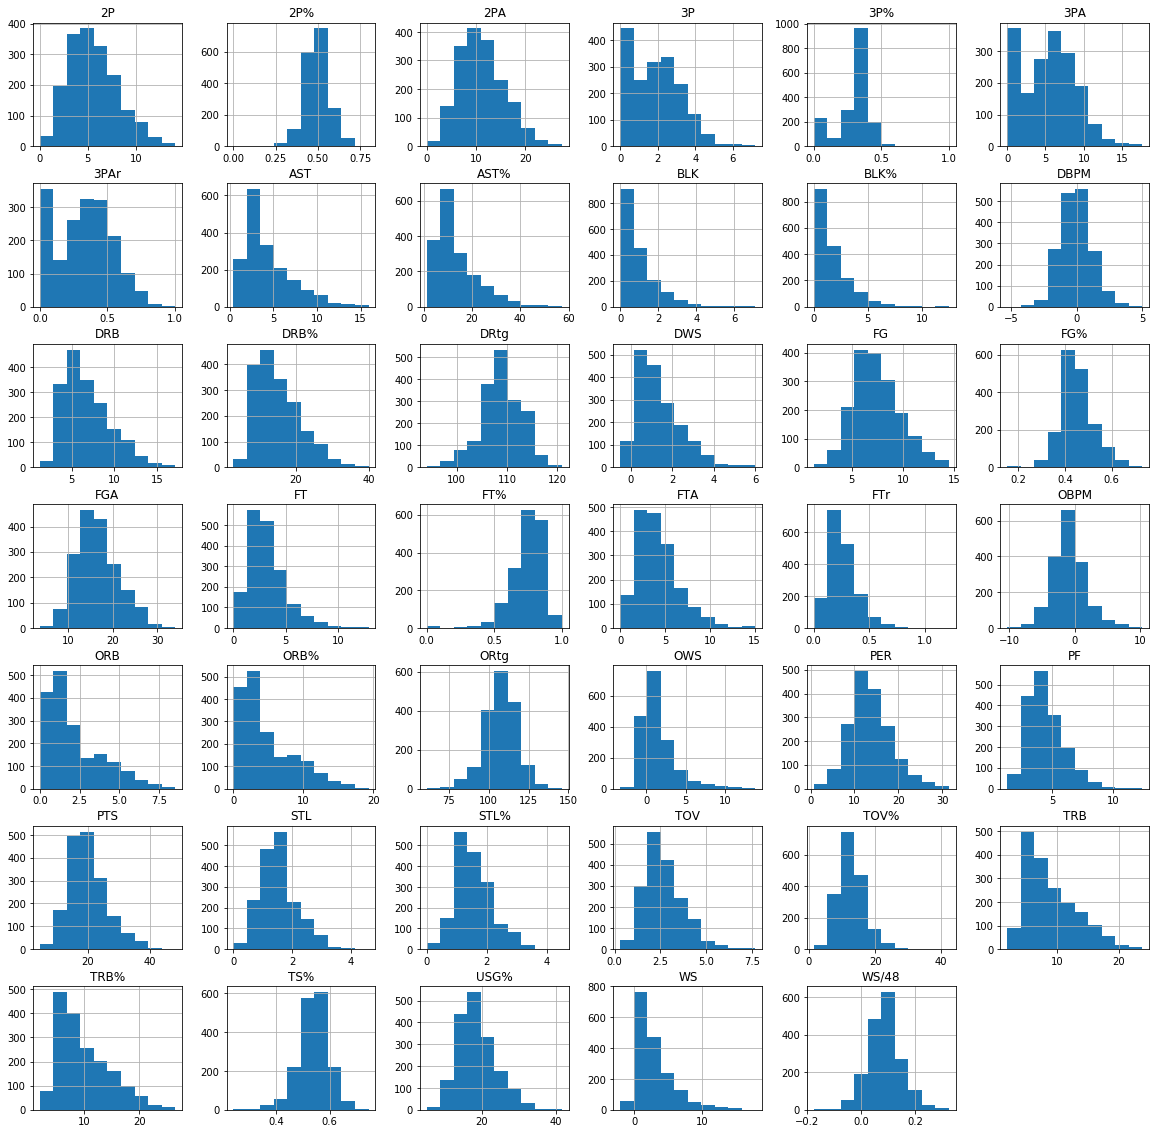

In [23]:
df_cutoff[['FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
      'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM']].hist(figsize=(20,20));

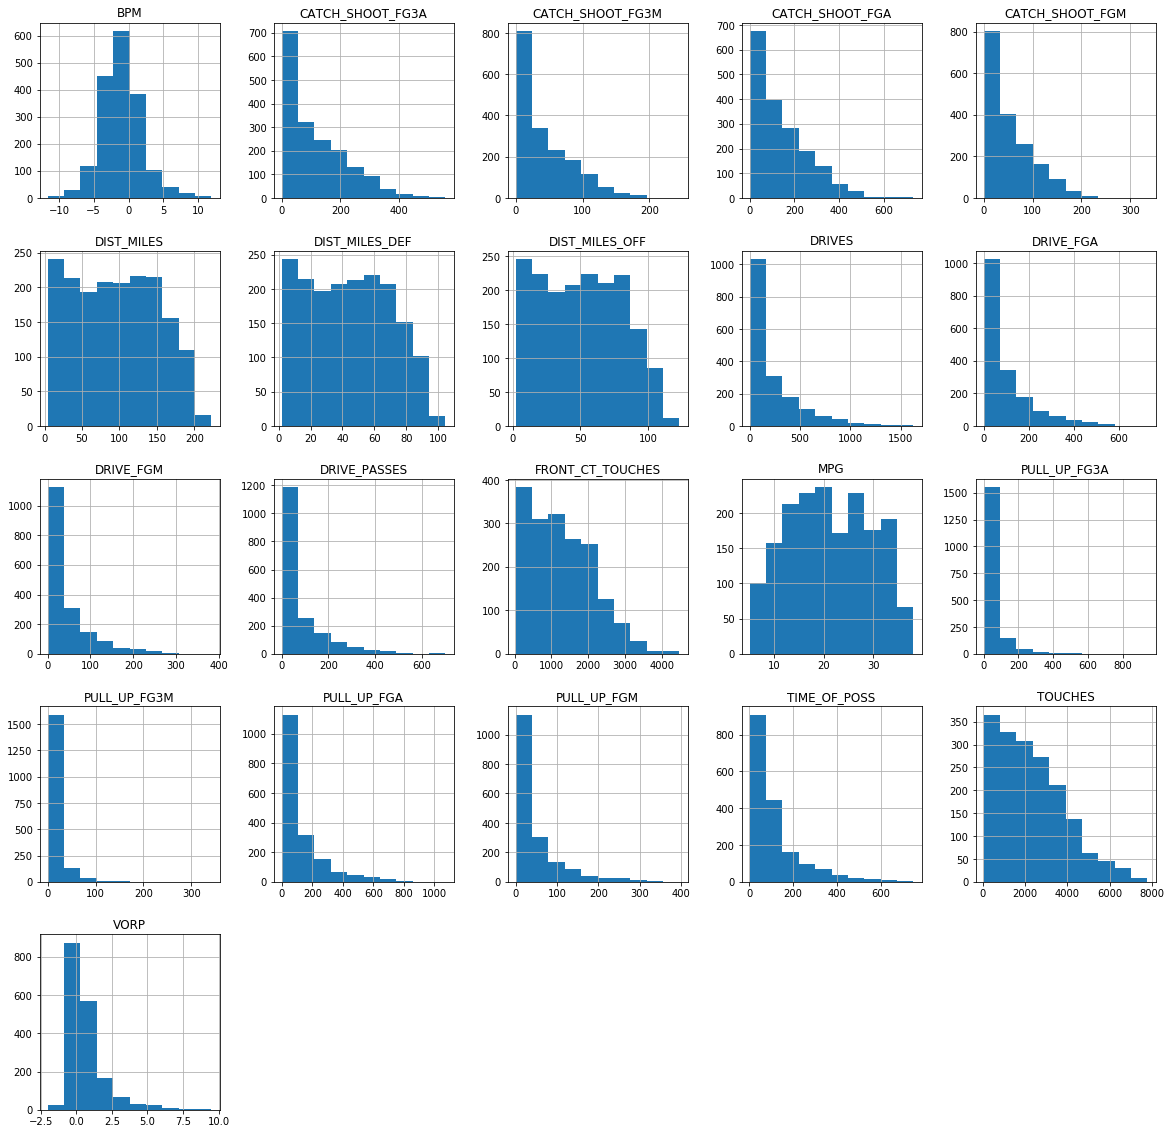

In [24]:
df_cutoff[['BPM', 'VORP', 'DRIVES', 'DRIVE_FGM', 'DRIVE_FGA', 'DRIVE_PASSES',
       'CATCH_SHOOT_FGM', 'CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3M',
       'CATCH_SHOOT_FG3A', 'TOUCHES', 'FRONT_CT_TOUCHES', 'TIME_OF_POSS',
       'PULL_UP_FGM', 'PULL_UP_FGA', 'PULL_UP_FG3M', 'PULL_UP_FG3A',
       'DIST_MILES', 'DIST_MILES_OFF', 'DIST_MILES_DEF', 'MPG']].hist(figsize=(20,20));

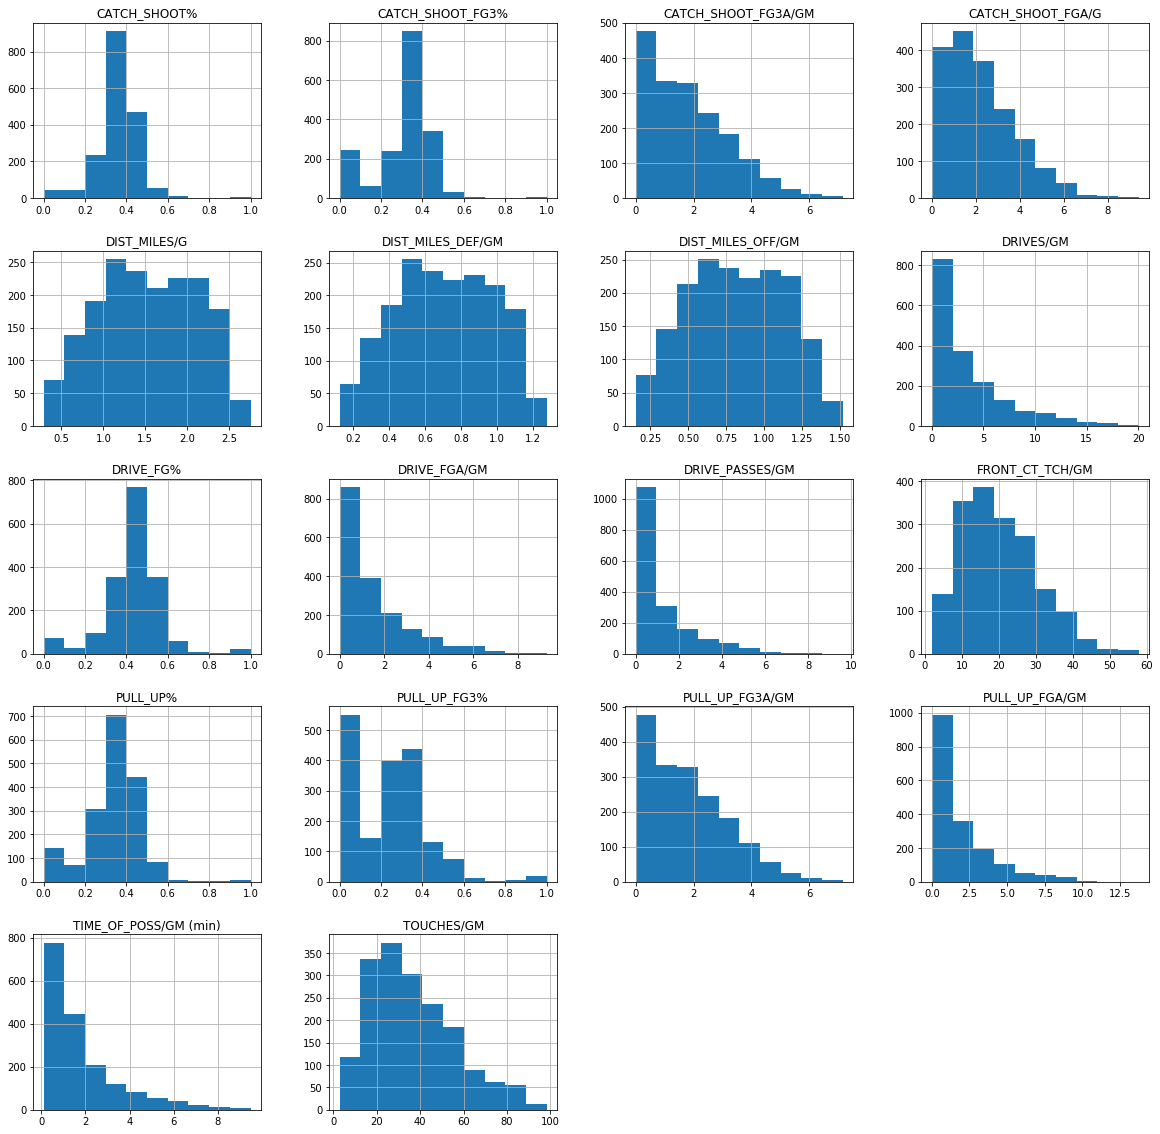

In [25]:
df_cutoff[['DRIVES/GM',
       'DRIVE_FGA/GM', 'DRIVE_FG%', 'DRIVE_PASSES/GM', 'CATCH_SHOOT%',
       'CATCH_SHOOT_FGA/G', 'CATCH_SHOOT_FG3%', 'CATCH_SHOOT_FG3A/GM',
       'TOUCHES/GM', 'FRONT_CT_TCH/GM', 'TIME_OF_POSS/GM (min)', 'PULL_UP%',
       'PULL_UP_FGA/GM', 'PULL_UP_FG3%', 'PULL_UP_FG3A/GM', 'DIST_MILES/G',
       'DIST_MILES_OFF/GM', 'DIST_MILES_DEF/GM']].hist(figsize=(20,20));

In [26]:
df_cutoff.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,DRIVES,DRIVE_FGM,DRIVE_FGA,DRIVE_PASSES,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,TOUCHES,FRONT_CT_TOUCHES,TIME_OF_POSS,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG3M,PULL_UP_FG3A,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,MPG,DRIVES/GM,DRIVE_FGA/GM,DRIVE_FG%,DRIVE_PASSES/GM,CATCH_SHOOT%,CATCH_SHOOT_FGA/G,CATCH_SHOOT_FG3%,CATCH_SHOOT_FG3A/GM,TOUCHES/GM,FRONT_CT_TCH/GM,TIME_OF_POSS/GM (min),PULL_UP%,PULL_UP_FGA/GM,PULL_UP_FG3%,PULL_UP_FG3A/GM,DIST_MILES/G,DIST_MILES_OFF/GM,DIST_MILES_DEF/GM
count,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000
mean,26.413657,57.929458,27.726862,1334.351016,7.462472,16.564898,0.451795,1.865576,5.384199,0.294178,5.596840,11.179233,0.496065,3.184876,4.258239,0.743801,2.159424,6.826016,8.986343,4.363375,1.539278,1.026524,2.672630,4.497009,19.973307,107.210497,108.869074,13.656998,0.540223,0.325408,0.259181,4.810948,15.221670,10.011851,13.505305,1.539165,1.728894,12.793679,18.731998,1.466817,1.356433,2.822009,0.087181,-0.896896,-0.058691,-0.956941,0.682223,0.674597,0.325407,223.082393,43.897856,95.854402,75.273702,53.531603,139.812077,41.685102,112.143341,2310.399549,1279.003950,115.115688,45.450339,119.254515,12.719526,39.163093,95.445937,51.273815,44.172573,21.264523,3.540259,1.515062,0.429093,1.201160,0.358844,2.212239,0.305284,1.778900,36.705978,20.239599,1.831810,0.335882,1.859277,0.227214,1.778900,1.524366,0.818775,0.705558
std,4.322788,20.650710,28.916963,782.972653,2.293902,4.579795,0.072143,1.345801,3.515589,0.133694,2.506829,4.566651,0.073850,1.870828,2.352846,0.122976,1.696203,2.759577,4.140425,2.738394,0.618557,0.929075,1.058477,1.512133,6.239033,9.990580,3.999268,4.805633,0.058496,0.206767,0.131942,3.770541,6.130254,4.600970,8.802592,0.618299,1.561067,4.215548,5.141272,2.018009,1.083555,2.835734,0.061933,2.550778,1.197818,2.933943,1.374407,0.206763,0.206763,264.798851,53.768438,110.995776,99.146665,49.049884,119.035410,41.793368,105.036235,1597.564365,850.219271,123.208911,60.889012,151.472319,24.012532,67.621768,55.215200,29.812910,25.513883,8.303754,3.696682,1.541959,0.144085,1.413594,0.096544,1.547646,0.143208,1.403790,19.328969,10.011252,1.693489,0.135802,2.068540,0.188604,1.403790,0.579001,0.314217,0.267040
min,19.000000,11.000000,0.000000,63.000000,1.300000,3.600000,0.152000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,1.900000,0.400000,0.000000,0.000000,0.300000,1.300000,4.400000,61.000000,94.000000,0.700000,0.240000,0.000000,0.000000,0.000000,2.900000,2.000000,1.200000,0.000000,0.000000,1.400000,5.200000,-3.300000,-0.500000,-2.100000,-0.175000,-10.300000,-5.300000,-11.600000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,34.000000,1.800000,0.000000,0.000000,0.000

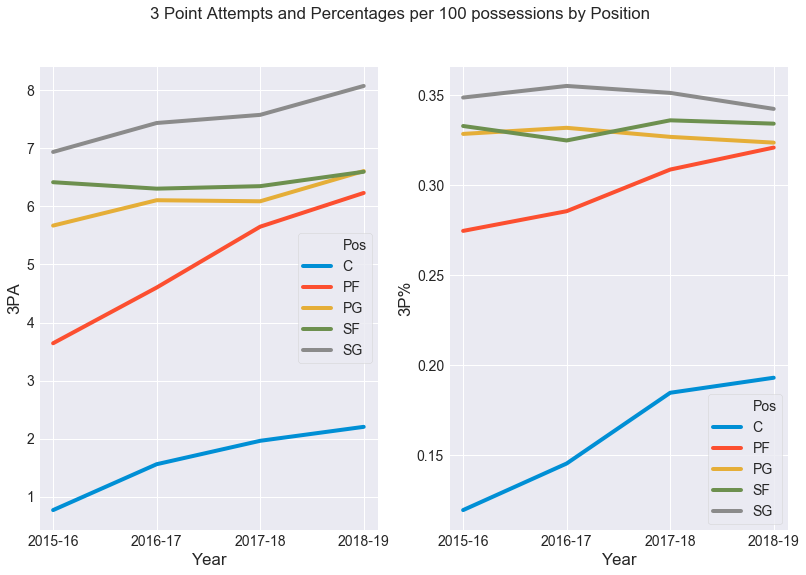

In [27]:
style.use('fivethirtyeight')
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8));
#ax1.set_title('3 Point Attempts per 100 Poss by Position')
#ax2.set_title('3 Point Percentage by Position')
fig.suptitle("3 Point Attempts and Percentages per 100 possessions by Position");
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x='Year', 
             y='3PA',
             hue='Pos', 
             ax = ax1);
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x = 'Year',
             y = '3P%',
             hue = 'Pos',
             ax= ax2);

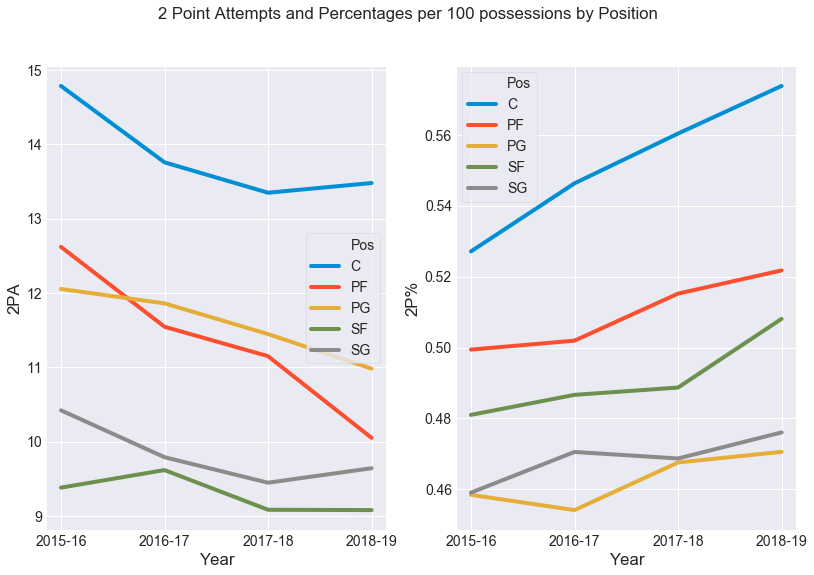

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8));
#ax1.set_title('2 Point Attempts by Position');
#ax2.set_title('2 Point Percentage by Position');
fig.suptitle("2 Point Attempts and Percentages per 100 possessions by Position");
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x='Year', 
             y='2PA',
             hue='Pos', 
             ax = ax1);
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x = 'Year',
             y = '2P%',
             hue = 'Pos',
             ax= ax2);

Text(0.5, 1.0, '2018-2019')

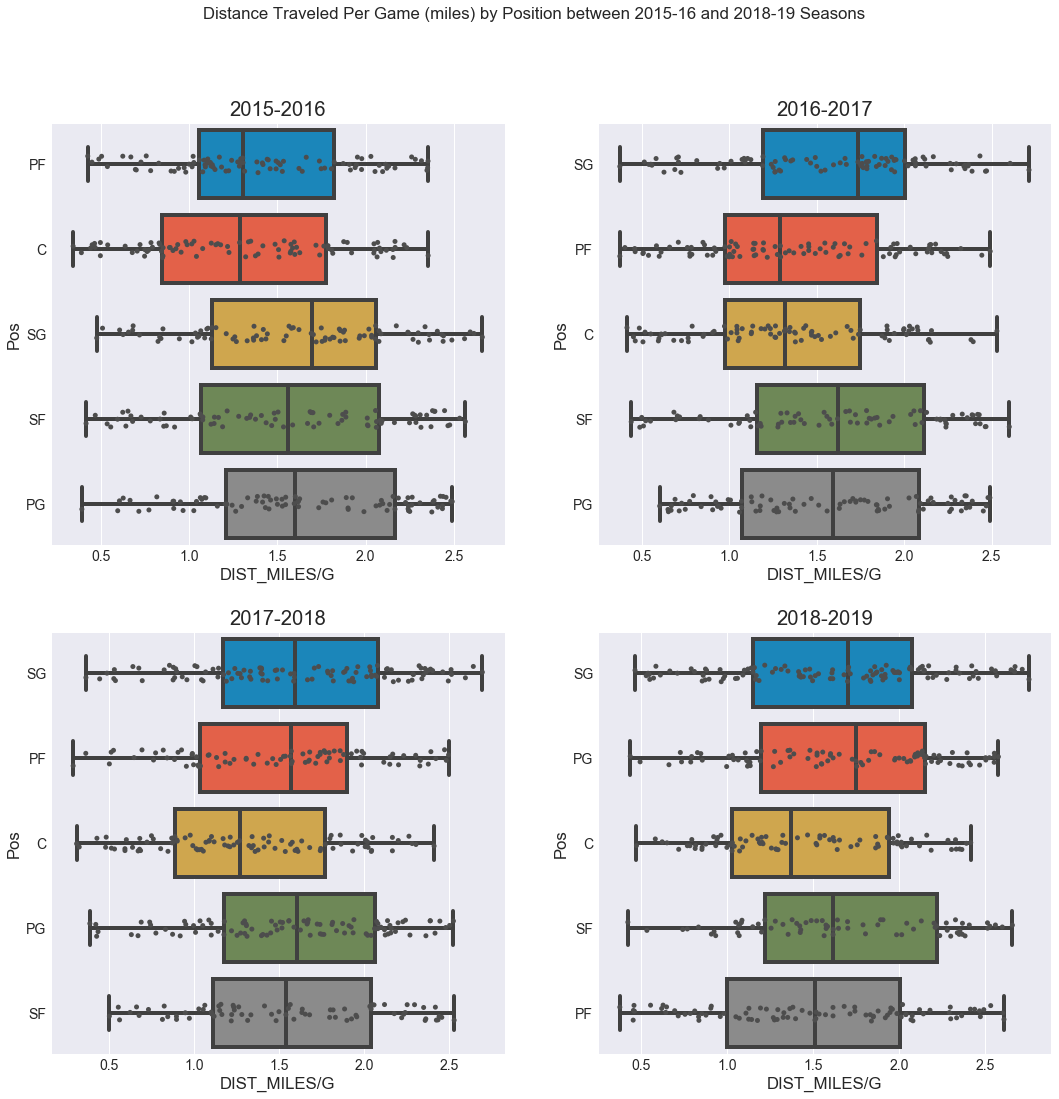

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')


Text(0.5, 1.0, '2018-2019')

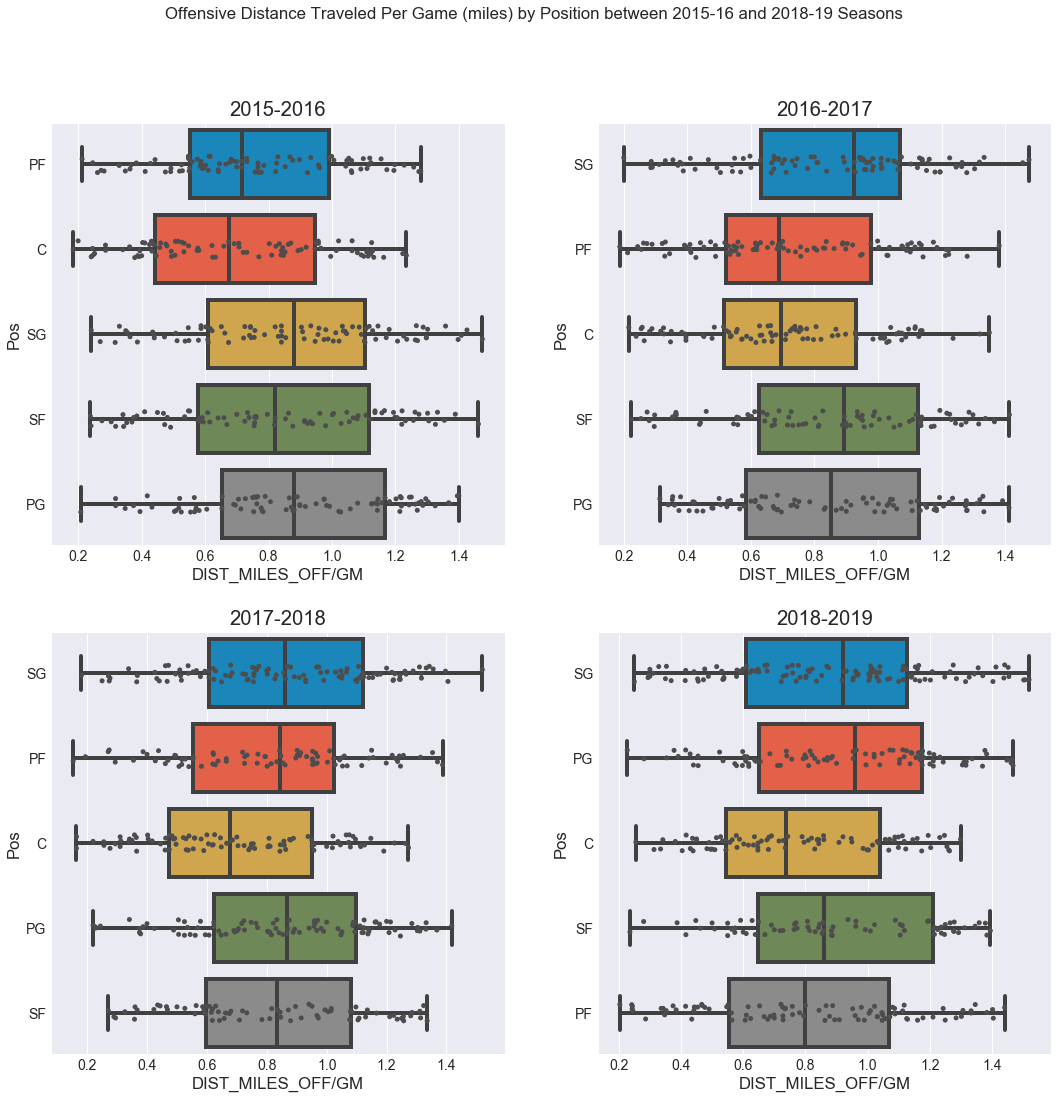

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Offensive Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')

Text(0.5, 1.0, '2018-2019')

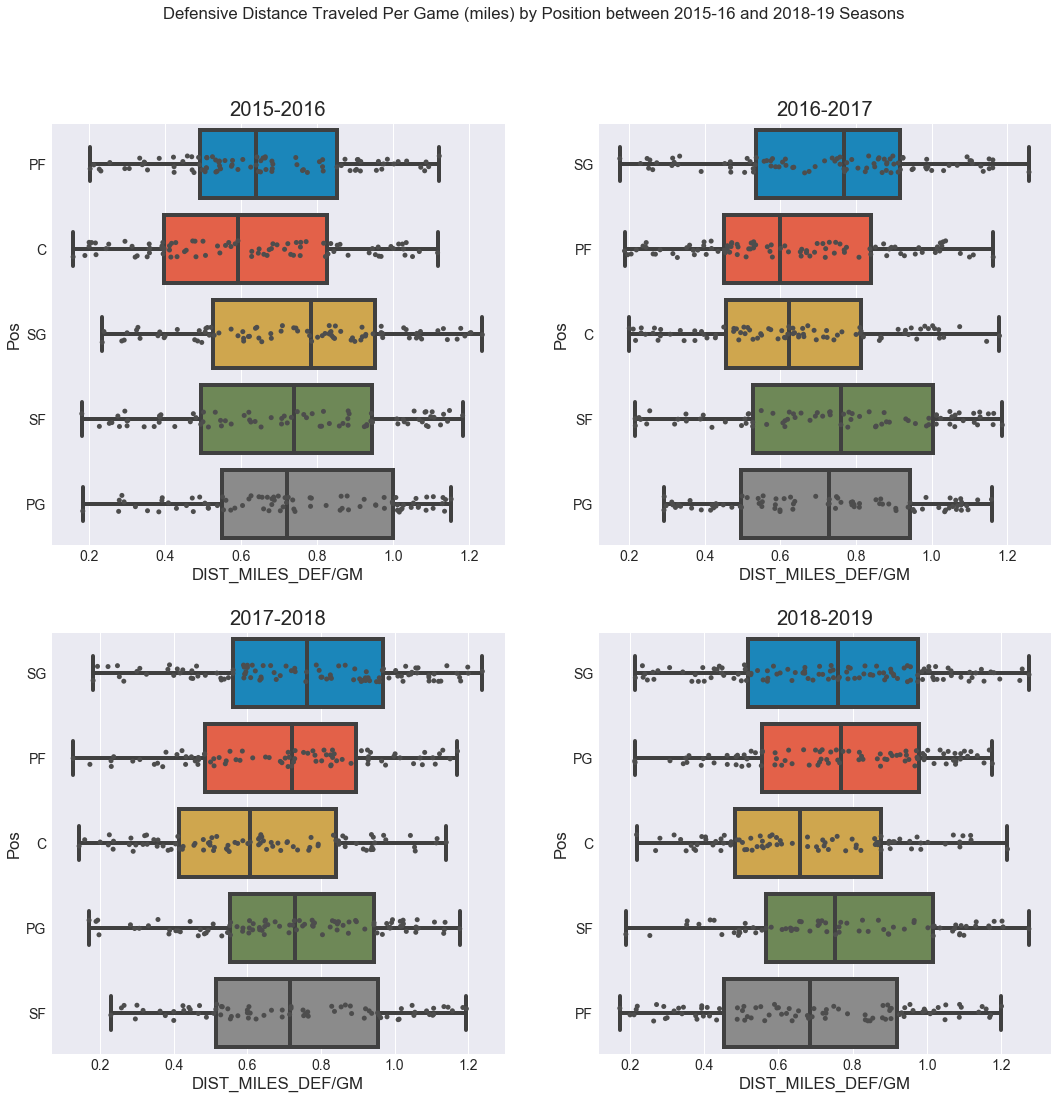

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Defensive Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')

In [ ]:
#touches, time of possession, front court touches
############################
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')

Text(0.5, 1.0, '2018-19')

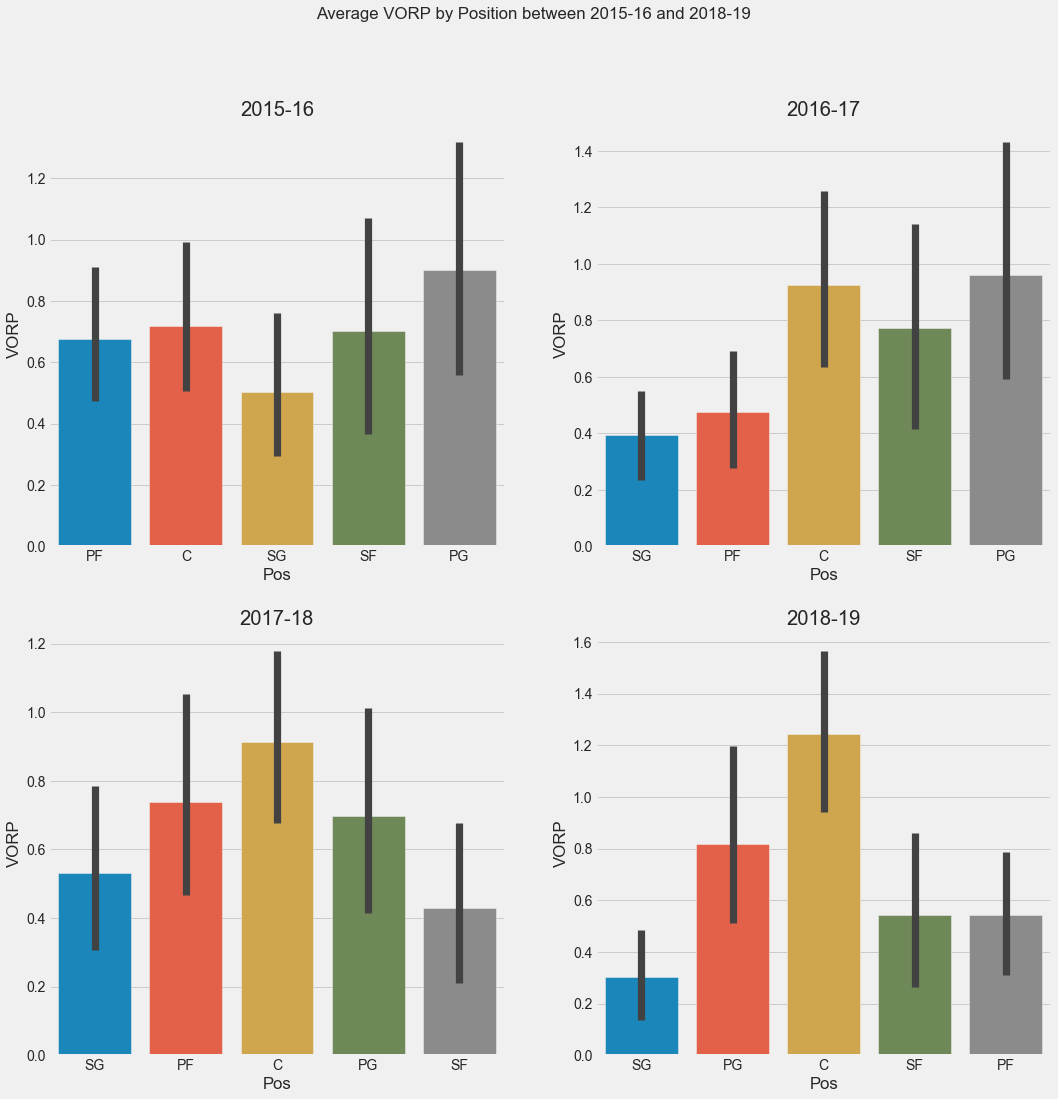

In [32]:
style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Average VORP by Position between 2015-16 and 2018-19')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
axs[0][0].set_title('2015-16')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
axs[0][1].set_title('2016-17')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
axs[1][0].set_title('2017-18')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
axs[1][1].set_title('2018-19')

In [33]:
### Look at top 5 VORPs per year for these seasons

In [34]:
df_cutoff.columns

Index(['PLAYER_NAME', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'pct_of_FGA_twos', 'pct_of_FGA_threes', 'DRIVES',
       'DRIVE_FGM', 'DRIVE_FGA', 'DRIVE_PASSES', 'CATCH_SHOOT_FGM',
       'CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3M', 'CATCH_SHOOT_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'TIME_OF_POSS', 'PULL_UP_FGM', 'PULL_UP_FGA',
       'PULL_UP_FG3M', 'PULL_UP_FG3A', 'DIST_MILES', 'DIST_MILES_OFF',
       'DIST_MILES_DEF', 'MPG', 'DRIVES/GM', 'DRIVE_FGA/GM', 'DRIVE_FG%',
       'DRIVE_PASSES/GM', 'CATCH_SHOOT%', 'CATCH_SHOOT_FGA/G',
       'CATCH_SHOOT_FG3%', 'CATCH_SHOOT_FG3A/GM', 'TOUCHES/GM',
       'FRONT_CT_TCH/GM', 'TIME_OF_POSS/GM (min)', 'PUL

In [35]:
df_modeling = df_cutoff.drop(columns=[ 'PLAYER_NAME','Age', 'Tm', 'G', 'GS','MP','DRIVES', '2P', '3P', '2PA', 
       '3P%', 'FT', 'TRB','DRIVE_FGM', 'DRIVE_FGA', 'DRIVE_PASSES', 'CATCH_SHOOT_FGM',
       'CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3M', 'CATCH_SHOOT_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'TIME_OF_POSS', 'PULL_UP_FGM', 'PULL_UP_FGA',
       'PULL_UP_FG3M', 'PULL_UP_FG3A', 'DIST_MILES', 'DIST_MILES_OFF',
       'DIST_MILES_DEF', 'MPG', 'Year', 'TRB%', 'DRB%', 'OWS', 'DWS', 'WS', 'BPM'
       ])

In [36]:
#vanilla logistic regression model

X = df_modeling.drop(columns=['Pos'])
y = df_modeling['Pos']

#train test split (75/25, or )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=123)

log_vanilla = LogisticRegression(solver='newton-cg', max_iter=1000)
log_vanilla.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [37]:
prediction_test = log_vanilla.predict(X_test)
prediction_train = log_vanilla.predict(X_train)

In [38]:
print('-'*40)
print('Training Accuracy Score:')
print(accuracy_score(y_train, prediction_train))

print('-'*40)
print('Testing Accuracy Score:')
print(accuracy_score(y_test, prediction_test))

print('-'*40)
print('Test Confusion Matrix:')
print(confusion_matrix(y_test, prediction_test))

print('-'*40)
print('Test Classification Matrix:')
print(classification_report(y_test, prediction_test))

----------------------------------------
Training Accuracy Score:
0.8036117381489842
----------------------------------------
Testing Accuracy Score:
0.7200902934537246
----------------------------------------
Test Confusion Matrix:
[[67 19  0  0  0]
 [15 57  0 15  0]
 [ 0  1 75  0  8]
 [ 2  8  2 44 20]
 [ 0  2  6 26 76]]
----------------------------------------
Test Classification Matrix:
              precision    recall  f1-score   support

           C       0.80      0.78      0.79        86
          PF       0.66      0.66      0.66        87
          PG       0.90      0.89      0.90        84
          SF       0.52      0.58      0.55        76
          SG       0.73      0.69      0.71       110

    accuracy                           0.72       443
   macro avg       0.72      0.72      0.72       443
weighted avg       0.73      0.72      0.72       443



In [39]:
C_values = [0.01, 0.1, 1, 10, 100]
scores = []
for c in C_values:
    log_vanilla = LogisticRegression(solver='newton-cg', max_iter=1000, C=c)
    log_vanilla.fit(X_train, y_train)
    prediction = log_vanilla.predict(X_test)
    score = accuracy_score(y_test, prediction)
    scores.append(score)
    

In [40]:
scores

[0.7381489841986456,
 0.7336343115124153,
 0.7200902934537246,
 0.7020316027088036,
 0.6952595936794582]

In [41]:
log_vanilla2 = LogisticRegression(solver='newton-cg', max_iter=1000, C=0.01)
log_vanilla2.fit(X_train, y_train)
prediction_train = log_vanilla2.predict(X_train)
prediction_test = log_vanilla2.predict(X_test)

print('-'*40)
print('Training Accuracy Score:')
print(accuracy_score(y_train, prediction_train))

print('-'*40)
print('Testing Accuracy Score:')
print(accuracy_score(y_test, prediction_test))

print('-'*40)
print('Test Confusion Matrix:')
print(confusion_matrix(y_test, prediction_test))

print('-'*40)
print('Test Classification Matrix:')
print(classification_report(y_test, prediction_test))



----------------------------------------
Training Accuracy Score:
0.763732129420617
----------------------------------------
Testing Accuracy Score:
0.7381489841986456
----------------------------------------
Test Confusion Matrix:
[[72 13  0  1  0]
 [15 55  1 14  2]
 [ 0  0 77  1  6]
 [ 2  6  2 46 20]
 [ 0  1  5 27 77]]
----------------------------------------
Test Classification Matrix:
              precision    recall  f1-score   support

           C       0.81      0.84      0.82        86
          PF       0.73      0.63      0.68        87
          PG       0.91      0.92      0.91        84
          SF       0.52      0.61      0.56        76
          SG       0.73      0.70      0.72       110

    accuracy                           0.74       443
   macro avg       0.74      0.74      0.74       443
weighted avg       0.74      0.74      0.74       443



In [42]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)
log_vanilla3 = LogisticRegression(solver='newton-cg', max_iter=1000, C=0.01)
log_vanilla3.fit(scaled_train, y_train)
prediction3_train = log_vanilla3.predict(scaled_train)
prediction3_test = log_vanilla3.predict(scaled_test)

print(accuracy_score(y_train, prediction3_train))
print(accuracy_score(y_test, prediction3_test))


0.5680963130173062
0.5846501128668171


In [43]:
###roc curve for multiclass problem

In [44]:
#Support Vector Machine - RBF
svc_vanilla = SVC(kernel='rbf')

svc_vanilla.fit(X_train, y_train)
svc_prediction_train = svc_vanilla.predict(X_train)
svc_prediction_test = svc_vanilla.predict(X_test)

print('-'*40)
print('Training Accuracy Score:')
print(accuracy_score(y_train, svc_prediction_train))

print('-'*40)
print('Testing Accuracy Score:')
print(accuracy_score(y_test, svc_prediction_test))

print('-'*40)
print('Test Confusion Matrix:')
print(confusion_matrix(y_test, svc_prediction_test))

print('-'*40)
print('Test Classification Matrix:')
print(classification_report(y_test, svc_prediction_test))

----------------------------------------
Training Accuracy Score:
0.6282919488337095
----------------------------------------
Testing Accuracy Score:
0.6275395033860045
----------------------------------------
Test Confusion Matrix:
[[67 14  0  0  5]
 [19 42  3  0 23]
 [ 0  1 73  0 10]
 [ 4 13  5  0 54]
 [ 3  2  9  0 96]]
----------------------------------------
Test Classification Matrix:
              precision    recall  f1-score   support

           C       0.72      0.78      0.75        86
          PF       0.58      0.48      0.53        87
          PG       0.81      0.87      0.84        84
          SF       0.00      0.00      0.00        76
          SG       0.51      0.87      0.64       110

    accuracy                           0.63       443
   macro avg       0.53      0.60      0.55       443
weighted avg       0.54      0.63      0.57       443



/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [45]:
#Support Vector Machine - Polynomial Kernel
degrees = list(range(1, 15))
for d in degrees:
    svc_poly_vanilla = SVC(kernel='poly', degree=d)

    svc_poly_vanilla.fit(X_train, y_train)
    svc_prediction_train = svc_poly_vanilla.predict(X_train)
    svc_prediction_test = svc_poly_vanilla.predict(X_test)
    
    print('-'*40)
    print(f'Degree: {d}')
    
    print('Training Accuracy Score:')
    print(accuracy_score(y_train, svc_prediction_train))

    print('Testing Accuracy Score:')
    print(accuracy_score(y_test, svc_prediction_test))
    print('-'*40)


----------------------------------------
Degree: 1
Training Accuracy Score:
0.5936794582392777
Testing Accuracy Score:
0.5756207674943566
----------------------------------------
----------------------------------------
Degree: 2
Training Accuracy Score:
0.6335590669676449
Testing Accuracy Score:
0.6343115124153499
----------------------------------------
----------------------------------------
Degree: 3
Training Accuracy Score:
0.6651617757712566
Testing Accuracy Score:
0.6794582392776524
----------------------------------------
----------------------------------------
Degree: 4
Training Accuracy Score:
0.6862302483069977
Testing Accuracy Score:
0.6772009029345373
----------------------------------------
----------------------------------------
Degree: 5
Training Accuracy Score:
0.708051166290444
Testing Accuracy Score:
0.690744920993228
----------------------------------------
----------------------------------------
Degree: 6
Training Accuracy Score:
0.7185854025583145
Testing Accu

In [46]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=150)
rfc.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))


Accuracy on training set: 0.781
Accuracy on test set: 0.679


In [47]:
#XGB Classifier
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=100)
xgb_clf.fit(X_train, y_train)
training_preds = xgb_clf.predict(X_train)
test_preds = xgb_clf.predict(X_test)

print(f"Training Accuracy: {accuracy_score(y_train, training_preds)}")
print(f"Testing Accuracy: {accuracy_score(y_test, test_preds)}")


Training Accuracy: 1.0
Testing Accuracy: 0.7223476297968398


In [48]:
X_train.shape

(1329, 51)

In [49]:
X_test.shape

(443, 51)

In [50]:
#K Nearest Neighbor with standard scaler
from sklearn.neighbors import KNeighborsClassifier
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

k_vals = [3, 5, 7, 9, 11]
for k in k_vals:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(scaled_train, y_train)
    knn_test_preds = clf_knn.predict(scaled_test)
    print('-'*40)
    print(f'# of Neighbors: {k}')
    print(accuracy_score(y_test, knn_test_preds))
    print('-'*40)




----------------------------------------
# of Neighbors: 3
0.6455981941309256
----------------------------------------
----------------------------------------
# of Neighbors: 5
0.6681715575620768
----------------------------------------
----------------------------------------
# of Neighbors: 7
0.6659142212189616
----------------------------------------
----------------------------------------
# of Neighbors: 9
0.6839729119638827
----------------------------------------
----------------------------------------
# of Neighbors: 11
0.6884875846501128
----------------------------------------


In [51]:
#K Nearest Neighbor with Min Max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

k_vals = [3, 5, 7, 9, 11]
for k in k_vals:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(scaled_train, y_train)
    knn_test_preds = clf_knn.predict(scaled_test)
    print('-'*40)
    print(f'# of Neighbors: {k}')
    print(accuracy_score(y_test, knn_test_preds))
    print('-'*40)

----------------------------------------
# of Neighbors: 3
0.6523702031602708
----------------------------------------
----------------------------------------
# of Neighbors: 5
0.6568848758465011
----------------------------------------
----------------------------------------
# of Neighbors: 7
0.654627539503386
----------------------------------------
----------------------------------------
# of Neighbors: 9
0.6839729119638827
----------------------------------------
----------------------------------------
# of Neighbors: 11
0.6884875846501128
----------------------------------------


In [52]:
#Hyperparameter Tuning
#Tuning Logistic Regression Model
from sklearn.model_selection import GridSearchCV
log_clf = LogisticRegression()
param_log = {'C':[0.01, 0.1, 1],
             'penalty': ['l2'],
             'solver': ['newton-cg', 'sag', 'lbfgs'], 
             'class_weight': [None, 'balanced'],
             'max_iter': [10000], }

grid_log = GridSearchCV(log_clf, param_grid=param_log, n_jobs=-1, scoring='accuracy', cv=5)
grid_log.fit(X_train, y_train)


grid_log.best_params_


{'C': 0.1,
 'class_weight': None,
 'max_iter': 10000,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [53]:
grid_log_train_predictions = grid_log.predict(X_train)
grid_log_test_predictions = grid_log.predict(X_test)

print(f'Training Accuracy Score: {accuracy_score(y_train, grid_log_train_predictions)}')
print(f'Testing Accuracy Score: {accuracy_score(y_test, grid_log_test_predictions)}')

Training Accuracy Score: 0.7900677200902935
Testing Accuracy Score: 0.7336343115124153


In [54]:
rf_clf = RandomForestClassifier()
param_rfc = {'criterion': ['gini', 'entropy'],
             'max_depth':[3, 4, 5],
             'min_samples_split': [2, 3, 4, 5],
             'n_estimators': [30, 50, 100, 150, 200]
            }
grid_rfc = GridSearchCV(rf_clf, param_grid=param_rfc, scoring='accuracy', cv=5, n_jobs=-1)
grid_rfc.fit(X_train, y_train)

grid_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [55]:
grid_rfc_train_predictions = grid_rfc.predict(X_train)
grid_rfc_test_predictions = grid_rfc.predict(X_test)

print(f'Training Accuracy Score: {accuracy_score(y_train, grid_rfc_train_predictions)}')
print(f'Testing Accuracy Score: {accuracy_score(y_test, grid_rfc_test_predictions)}')

Training Accuracy Score: 0.782543265613243
Testing Accuracy Score: 0.6862302483069977


In [55]:
xgb_classifier = xgb.XGBClassifier()
param_xgb = {'n_estimators': [30, 100, 150, 200],
             'max_depth':[3, 4, 5],
             'learning_rate': [0.001, 0.01], 
             'booster':['gbtree', 'dart'],
             'gamma': [0, 1, 10],
             'min_child_weight': [3, 10]
             }
grid_xgb = GridSearchCV(xgb_classifier, param_grid=param_xgb, scoring='accuracy', cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

{'booster': 'gbtree',
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 200}

In [56]:
grid_xgb_train_predictions = grid_xgb.predict(X_train)
grid_xgb_test_predictions = grid_xgb.predict(X_test)

print(f'Training Accuracy Score: {accuracy_score(y_train, grid_xgb_train_predictions)}')
print(f'Testing Accuracy Score: {accuracy_score(y_test, grid_xgb_test_predictions)}')

Training Accuracy Score: 0.8382242287434161
Testing Accuracy Score: 0.6952595936794582


In [57]:
svc_clf = SVC()
param_svc = [{'C':[0.01, 1, 100],
             'kernel': ['linear', 'rbf', 'sigmoid'], 
             'gamma': [0.1, 1.0, 10.0],
             }, 
            {'C':[0.01, 1, 100],
             'kernel': ['poly'],
             'gamma':[0.1, 1.0, 10.0], 
             'degree':[2, 4, 8],
             }]

grid_SVC = GridSearchCV(svc_clf, param_grid=param_svc, scoring='accuracy', cv=5, n_jobs=-1)
grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_





{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

In [60]:
grid_svc_train_predictions = grid_SVC.predict(X_train)
grid_svc_test_predictions = grid_SVC.predict(X_test)

print(f'Training Accuracy:{accuracy_score(y_train, grid_svc_train_predictions)}')
print(f'Test Accuracy: {accuracy_score(y_test, grid_svc_test_predictions)}')

Training Accuracy:0.8164033107599699
Test Accuracy: 0.7200902934537246


In [56]:
df_modeling.columns

Index(['Pos', 'FG', 'FGA', 'FG%', '3PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'WS/48',
       'OBPM', 'DBPM', 'VORP', 'pct_of_FGA_twos', 'pct_of_FGA_threes',
       'DRIVES/GM', 'DRIVE_FGA/GM', 'DRIVE_FG%', 'DRIVE_PASSES/GM',
       'CATCH_SHOOT%', 'CATCH_SHOOT_FGA/G', 'CATCH_SHOOT_FG3%',
       'CATCH_SHOOT_FG3A/GM', 'TOUCHES/GM', 'FRONT_CT_TCH/GM',
       'TIME_OF_POSS/GM (min)', 'PULL_UP%', 'PULL_UP_FGA/GM', 'PULL_UP_FG3%',
       'PULL_UP_FG3A/GM', 'DIST_MILES/G', 'DIST_MILES_OFF/GM',
       'DIST_MILES_DEF/GM'],
      dtype='object')

In [57]:
df_modeling.describe()

,FG,FGA,FG%,3PA,2P%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,AST%,STL%,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,DRIVES/GM,DRIVE_FGA/GM,DRIVE_FG%,DRIVE_PASSES/GM,CATCH_SHOOT%,CATCH_SHOOT_FGA/G,CATCH_SHOOT_FG3%,CATCH_SHOOT_FG3A/GM,TOUCHES/GM,FRONT_CT_TCH/GM,TIME_OF_POSS/GM (min),PULL_UP%,PULL_UP_FGA/GM,PULL_UP_FG3%,PULL_UP_FG3A/GM,DIST_MILES/G,DIST_MILES_OFF/GM,DIST_MILES_DEF/GM
count,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000
mean,7.462472,16.564898,0.451795,5.384199,0.496065,4.258239,0.743801,2.159424,6.826016,4.363375,1.539278,1.026524,2.672630,4.497009,19.973307,107.210497,108.869074,13.656998,0.540223,0.325408,0.259181,4.810948,13.505305,1.539165,1.728894,12.793679,18.731998,0.087181,-0.896896,-0.058691,0.682223,0.674597,0.325407,3.540259,1.515062,0.429093,1.201160,0.358844,2.212239,0.305284,1.778900,36.705978,20.239599,1.831810,0.335882,1.859277,0.227214,1.778900,1.524366,0.818775,0.705558
std,2.293902,4.579795,0.072143,3.515589,0.073850,2.352846,0.122976,1.696203,2.759577,2.738394,0.618557,0.929075,1.058477,1.512133,6.239033,9.990580,3.999268,4.805633,0.058496,0.206767,0.131942,3.770541,8.802592,0.618299,1.561067,4.215548,5.141272,0.061933,2.550778,1.197818,1.374407,0.206763,0.206763,3.696682,1.541959,0.144085,1.413594,0.096544,1.547646,0.143208,1.403790,19.328969,10.011252,1.693489,0.135802,2.068540,0.188604,1.403790,0.579001,0.314217,0.267040
min,1.300000,3.600000,0.152000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,0.400000,0.000000,0.000000,0.300000,1.300000,4.400000,61.000000,94.000000,0.700000,0.240000,0.000000,0.000000,0.000000,1.200000,0.000000,0.000000,1.400000,5.200000,-0.175000,-10.300000,-5.300000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.842105,1.894737,0.094737,0.000000,0.000000,0.000000,0.000000,0.286667,0.153333,0.126667
25%,5.800000,13.300000,0.408000,2.700000,0.454000,2.575000,0.685000,0.900000,4.700000,2.400000,1.100000,0.400000,1.900000,3.400000,15.500000,102.000000,106.000000,10.500000,0.508000,0.168500,0.167000,1.900000,7.200000,1.100000,0.700000,9.900000,15.075000,0.048000,-2.400000,-0.900000,-0.100000,0.529750,0.168500,0.845553,0.379405,0.376594,0.200000,0.324503,1.017801,0.272727,0.635606,21.712185,12.398858,0.664071,0.289419,0.351233,0.000000,0.635606,1.068389,0.570219,0.498365
50%,7.200000,16.100000,0.443000,5.600000,0.494000,3.800000,0.764000,1.500000,6.300000,3.400000,1.500000,0.700000,2.500000,4.200000,19.250000,108.000000,109.000000,13.100000,0.543000,0.338500,0.237000,3.400000,10.500000,1.500000,1.200000,12.300000,17.900000,0.086000,-1.000000,-0.100000,0.200000,0.661500,0.338500,2.165865,0.965749,0.443110,0.647059,0.368421,1.919986,0.348125,1.574916,33.061181,18.737171,1.190146,0.358586,1.104102,0.258065,1.574916,1.517685,0.812569,0.707152
75%,8.900000,19.400000,0.487250,7.900000,0.539000,5.500000,0.826250,3.200000,8.600000,5.800000,1.900000,1.400000,3.300000,5.300000,23.500000,114.000000,112.000000,16.400000,0.577000,0.470250,0.324000,7.100000,17.700000,1.900000,2.300000,15.100000,21.900000,0.122000,0.500000,0.700000,1.000000,0.831500,0.470250,5.000000,2.166667,0.500000,1.732890,0.407538,3.144095,0.391304,2.697555,48.568313,26.501582,2.410422,0.407936,2.666667,0.346274,2.697555,2.015551,1.081803,0.928248
max,14.500000,34.000000,0.731000,17.600000,0.800000,15.100000,1.000000,8.500000,17.100000,15.900000,4.

In [58]:
df_modeling.groupby('Pos').median()

,FG,FGA,FG%,3PA,2P%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,AST%,STL%,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,DRIVES/GM,DRIVE_FGA/GM,DRIVE_FG%,DRIVE_PASSES/GM,CATCH_SHOOT%,CATCH_SHOOT_FGA/G,CATCH_SHOOT_FG3%,CATCH_SHOOT_FG3A/GM,TOUCHES/GM,FRONT_CT_TCH/GM,TIME_OF_POSS/GM (min),PULL_UP%,PULL_UP_FGA/GM,PULL_UP_FG3%,PULL_UP_FG3A/GM,DIST_MILES/G,DIST_MILES_OFF/GM,DIST_MILES_DEF/GM
Pos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,7.9,14.8,0.5305,0.2,0.5505,5.0,0.706,4.4,9.9,2.7,1.2,2.1,2.7,5.65,19.55,114.0,106,16.9,0.5785,0.0145,0.343,9.9,8.5,1.2,3.4,13.2,17.45,0.140,-0.5,0.45,0.5,0.9855,0.0145,0.424431,0.233904,0.456439,0.086975,0.371402,0.754032,0.000000,0.056624,28.378843,17.108206,0.764575,0.333333,0.174676,0.000000,0.056624,1.320714,0.696053,0.622917
PF,7.3,15.8,0.4540,4.9,0.5120,3.8,0.738,2.6,8.2,2.7,1.3,1.0,2.3,4.60,19.50,108.0,109,13.8,0.5480,0.3010,0.239,5.8,8.2,1.3,1.7,11.4,17.70,0.093,-0.9,-0.10,0.3,0.6990,0.3010,1.227848,0.600000,0.437500,0.278689,0.368421,2.245614,0.347826,1.700000,32.372881,18.804348,0.862295,0.333333,0.507042,0.166667,1.700000,1.418182,0.757812,0.656250
PG,7.1,17.0,0.4240,5.8,0.4680,4.0,0.800,0.9,4.6,7.9,1.7,0.4,3.4,3.70,19.70,105.0,110,13.1,0.5220,0.3380,0.233,2.0,24.2,1.7,0.6,14.7,19.50,0.076,-1.0,-0.40,0.2,0.6620,0.3380,6.311111,2.275862,0.450000,2.559322,0.366197,1.543478,0.360902,1.428571,48.589041,19.696203,3.687805,0.377916,2.638889,0.305785,1.428571,1.619672,0.885185,0.736364
SF,6.4,15.0,0.4330,6.3,0.4910,3.3,0.764,1.4,6.2,2.9,1.6,0.7,2.0,4.00,17.30,106.0,109,11.6,0.5390,0.4200,0.216,3.1,8.7,1.6,1.2,11.1,16.40,0.073,-1.3,0.00,0.2,0.5800,0.4200,2.173077,1.016129,0.436170,0.661538,0.359375,2.354839,0.351351,2.127660,27.800000,18.287879,0.931818,0.351648,1.000000,0.283019,2.127660,1.583582,0.846667,0.731579
SG,7.2,17.1,0.4220,7.5,0.4720,3.2,0.798,0.9,4.7,3.6,1.5,0.5,2.3,3.70,19.60,104.0,111,11.6,0.5340,0.4420,0.188,2.0,11.0,1.5,0.8,10.8,18.40,0.065,-1.3,-0.40,0.1,0.5580,0.4420,3.031250,1.395833,0.435897,1.000000,0.372642,2.594595,0.370262,2.383333,30.513514,19.583333,1.276250,0.375000,2.104478,0.308511,2.383333,1.691429,0.893827,0.769355


In [59]:
###log transform variables 
### we will only transform columns with values 0 and above

In [60]:
def log_transform(x):
    if x >= 0:
      if x == 0 or x == 0.0:
        x = np.log(x+1)
      else: 
        x = np.log(x)
    return x

In [61]:
from sklearn.pipeline import Pipeline

X_train_log = X_train.applymap(log_transform)
X_test_log = X_test.applymap(log_transform)

In [62]:
pipe_log = Pipeline([('ss', StandardScaler()), ('log_reg', LogisticRegression(solver='newton-cg', C=0.01, 
                                                                                        max_iter=10000))])
pipe_log.fit(X_train_log, y_train)

print(f'Training Accuracy: {accuracy_score(y_train, pipe_log.predict(X_train_log))}')
print(f'Testing Accuracy: {accuracy_score(y_test, pipe_log.predict(X_test_log))}')

Training Accuracy: 0.7396538750940557
Testing Accuracy: 0.7200902934537246


In [63]:
pipe_rf = Pipeline([('ss', StandardScaler()), 
                    ('rfc', RandomForestClassifier(n_estimators=80, min_samples_split=6, criterion='gini', 
                                        min_weight_fraction_leaf=0.15, max_features='log2', max_depth=5))])

pipe_rf.fit(X_train_log, y_train)
print(f'Training: {pipe_rf.score(X_train_log, y_train)}')
print(f'Testing: {pipe_rf.score(X_test_log, y_test)}')

Training: 0.6388261851015802
Testing: 0.6252821670428894


In [64]:
pipe_xgb = Pipeline([('ss', StandardScaler()), 
                     ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=3, 
                                               learning_rate=0.0001, min_child_weight=10,
                                               gamma = 1, subsample=0.5, max_delta_step=2))])

pipe_xgb.fit(X_train_log, y_train)
print(f'Training: {pipe_xgb.score(X_train_log, y_train)}')
print(f'Testing: {pipe_xgb.score(X_test_log, y_test)}')

Training: 0.6824680210684725
Testing: 0.6636568848758465


In [65]:
pipe_svc = Pipeline([('ss', StandardScaler()), ('svc', SVC(kernel='linear', C=1, gamma=0.1))])
pipe_svc.fit(X_train_log, y_train)

print(f'Training: {pipe_svc.score(X_train_log, y_train)}')
print(f'Testing: {pipe_svc.score(X_test_log, y_test)}')

Training: 0.8066215199398044
Testing: 0.7404063205417607


In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe_svc, X_train_log, y_train, cv=10, scoring='accuracy')
np.mean(scores)

0.7433697881066301

In [67]:
pipe_linear_svc = Pipeline([('ss', StandardScaler()),
                            ('lin_svc', LinearSVC(C=1, max_iter=50000))]) 
pipe_linear_svc.fit(X_train_log, y_train)
print(f'Training: {pipe_linear_svc.score(X_train_log, y_train)}')
print(f'Testing: {pipe_linear_svc.score(X_test_log, y_test)}')

Training: 0.7659894657637322
Testing: 0.7336343115124153


In [68]:
scores = cross_val_score(pipe_linear_svc, X_train_log, y_train, cv=10, scoring='accuracy')
np.mean(scores)

0.7321029847345637

In [69]:
pipe_nu_svc = Pipeline([('ss', StandardScaler()),
                            ('nu_svc', NuSVC(nu=0.5, kernel='linear', gamma='auto', decision_function_shape='ovo'))]) 
pipe_nu_svc.fit(X_train_log, y_train)
print(f'Training: {pipe_nu_svc.score(X_train_log, y_train)}')
print(f'Testing: {pipe_nu_svc.score(X_test_log, y_test)}')

Training: 0.7539503386004515
Testing: 0.7291196388261851


In [70]:
scores = cross_val_score(pipe_nu_svc, X_train_log, y_train, cv=10, scoring='accuracy')
np.mean(scores)

0.7245500113921166

In [71]:
###SVC with a linear kernel seems to perform the best on both untransformed and unscaled data.
###The linear kernel performed slightly better on scaled, transformed data so we will perform GridSearchCV
### on the transformed data to ensure we have an optimized set of hyperparameters
###we will also enable proabibility as True so we can see what

In [72]:
pipe_svc_2 = Pipeline([('ss', StandardScaler()), ('svc', SVC())])
param_grid_svc_2 = {'svc__kernel': ['linear'],
                    'svc__C': [0.1, 1, 10],
                    'svc__gamma': ['scale', 'auto', 0.1, 1, 10], 
                    'svc__probability':[True]}



In [73]:
grid_svc_2 = GridSearchCV(estimator=pipe_svc_2, 
                          param_grid=param_grid_svc_2,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
grid_svc_2.fit(X_train_log, y_train)
grid_svc_2.best_params_

{'svc__C': 1,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear',
 'svc__probability': True}

In [74]:
print(f'Training Accuracy: {grid_svc_2.score(X_train_log, y_train)}')
cross_val_scores = cross_val_score(grid_svc_2, X_train_log, y_train, cv=10, scoring='accuracy')
print(f'Cross Validation Average:{np.mean(cross_val_scores)}')
print(f'Testing Accuracy: {grid_svc_2.score(X_test_log, y_test)}')

Training Accuracy: 0.8066215199398044
Cross Validation Average:0.7411141490088858
Testing Accuracy: 0.7404063205417607


In [75]:
print('-'*40)
print('Test Confusion Matrix:')
print(confusion_matrix(y_test, grid_svc_2.predict(X_test_log)))

print('-'*40)
print('Test Classification Matrix:')
print(classification_report(y_test, grid_svc_2.predict(X_test_log)))

----------------------------------------
Test Confusion Matrix:
[[70 15  0  1  0]
 [21 52  0 14  0]
 [ 0  0 80  0  4]
 [ 2  6  1 50 17]
 [ 0  2 10 22 76]]
----------------------------------------
Test Classification Matrix:
              precision    recall  f1-score   support

           C       0.75      0.81      0.78        86
          PF       0.69      0.60      0.64        87
          PG       0.88      0.95      0.91        84
          SF       0.57      0.66      0.61        76
          SG       0.78      0.69      0.73       110

    accuracy                           0.74       443
   macro avg       0.74      0.74      0.74       443
weighted avg       0.74      0.74      0.74       443



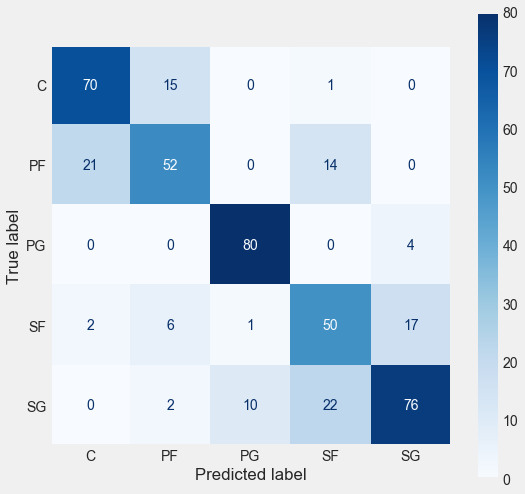

In [76]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
plot_confusion_matrix(grid_svc_2, X_test_log, y_test, cmap='Blues', ax=ax)


In [77]:
svc_optimized = grid_svc_2.best_estimator_.named_steps['svc']

In [78]:
svc_optimized.coef_.shape

(10, 51)

In [79]:
###Multiclass uses one v one method
## C vs PF, C vs PG, C vs SF, C vs SG, PF vs PG, PF vs SF, PF vs SG, PG vs SF, PG vs SG, SF vs SG
##Take absolute value for each list and determine top 5 most important features 

In [80]:
#Store coefficients for each multiclass combination
C_vs_PF = list(zip(X_test_log.columns, svc_optimized.coef_[0]))
C_vs_PG = list(zip(X_test_log.columns, svc_optimized.coef_[1]))
C_vs_SF = list(zip(X_test_log.columns, svc_optimized.coef_[2]))
C_vs_SG = list(zip(X_test_log.columns, svc_optimized.coef_[3]))
PF_vs_PG = list(zip(X_test_log.columns, svc_optimized.coef_[4]))
PF_vs_SF = list(zip(X_test_log.columns, svc_optimized.coef_[5]))
PF_vs_SG = list(zip(X_test_log.columns, svc_optimized.coef_[6]))
PG_vs_SF = list(zip(X_test_log.columns, svc_optimized.coef_[7]))
PG_vs_SG = list(zip(X_test_log.columns, svc_optimized.coef_[8]))
SF_vs_SG = list(zip(X_test_log.columns, svc_optimized.coef_[9]))

In [81]:
C_vs_PF_sorted = sorted(C_vs_PF, key=lambda ele: abs(ele[1]), reverse=True)
C_vs_PG_sorted = sorted(C_vs_PG, key=lambda ele: abs(ele[1]), reverse=True)
C_vs_SF_sorted = sorted(C_vs_SF, key=lambda ele: abs(ele[1]), reverse=True)
C_vs_SG_sorted = sorted(C_vs_SG, key=lambda ele: abs(ele[1]), reverse=True)
PF_vs_PG_sorted = sorted(PF_vs_PG, key=lambda ele: abs(ele[1]), reverse=True)
PF_vs_SF_sorted = sorted(PF_vs_SF, key=lambda ele: abs(ele[1]), reverse=True)
PF_vs_SG_sorted = sorted(PF_vs_SG, key=lambda ele: abs(ele[1]), reverse=True)
PG_vs_SF_sorted = sorted(PG_vs_SF, key=lambda ele: abs(ele[1]), reverse=True)
PG_vs_SG_sorted = sorted(PG_vs_SG, key=lambda ele: abs(ele[1]), reverse=True)
SF_vs_SG_sorted = sorted(SF_vs_SG, key=lambda ele: abs(ele[1]), reverse=True)

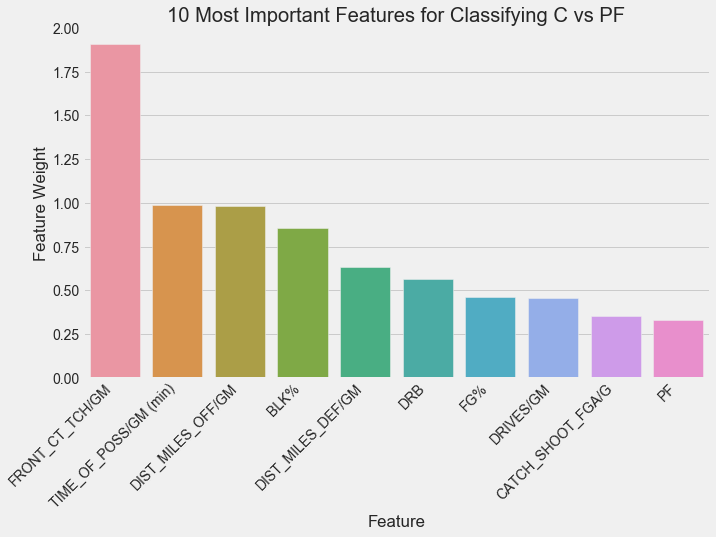

In [82]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in C_vs_PF_sorted[:10]],
            y=[abs(i[1]) for i in C_vs_PF_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying C vs PF')
plt.xticks(rotation=45, horizontalalignment='right');


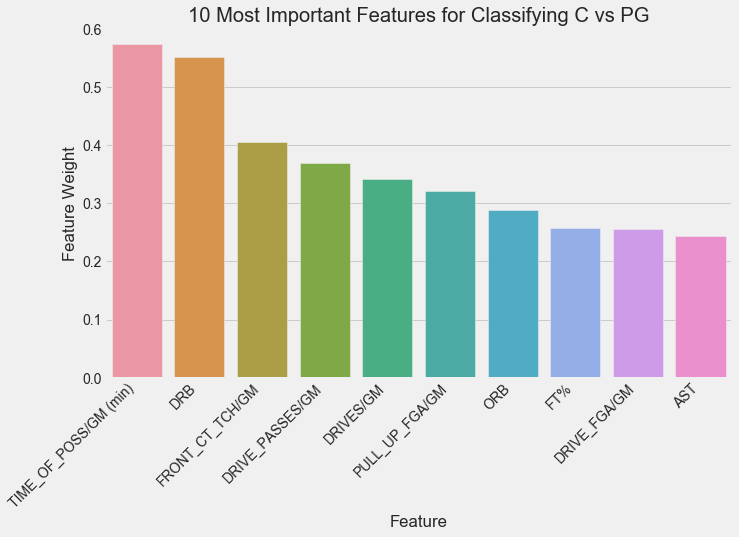

In [83]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in C_vs_PG_sorted[:10]],
            y=[abs(i[1]) for i in C_vs_PG_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying C vs PG')
plt.xticks(rotation=45, horizontalalignment='right');

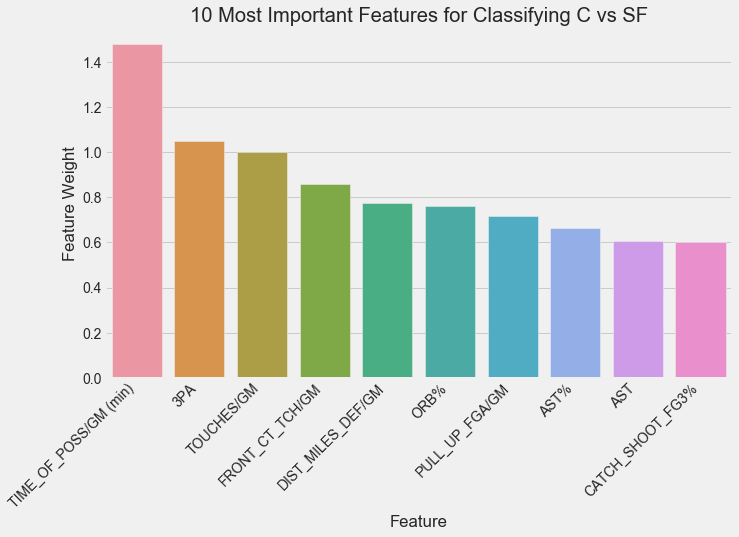

In [84]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in C_vs_SF_sorted[:10]],
            y=[abs(i[1]) for i in C_vs_SF_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying C vs SF')
plt.xticks(rotation=45, horizontalalignment='right');

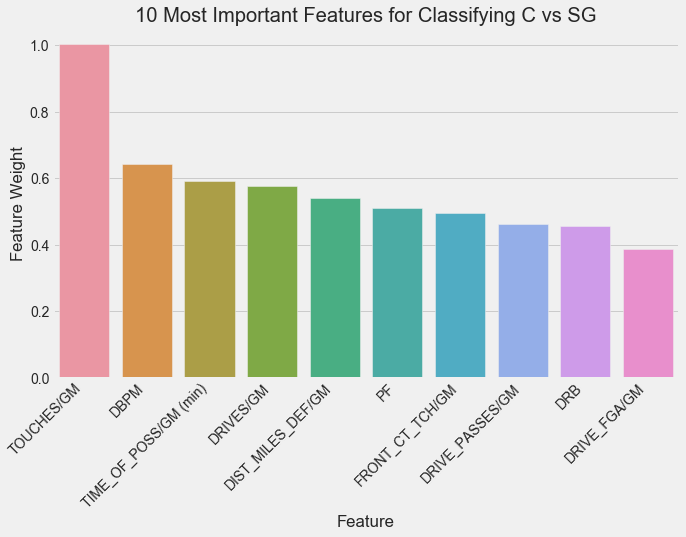

In [85]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in C_vs_SG_sorted[:10]],
            y=[abs(i[1]) for i in C_vs_SG_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying C vs SG')
plt.xticks(rotation=45, horizontalalignment='right');

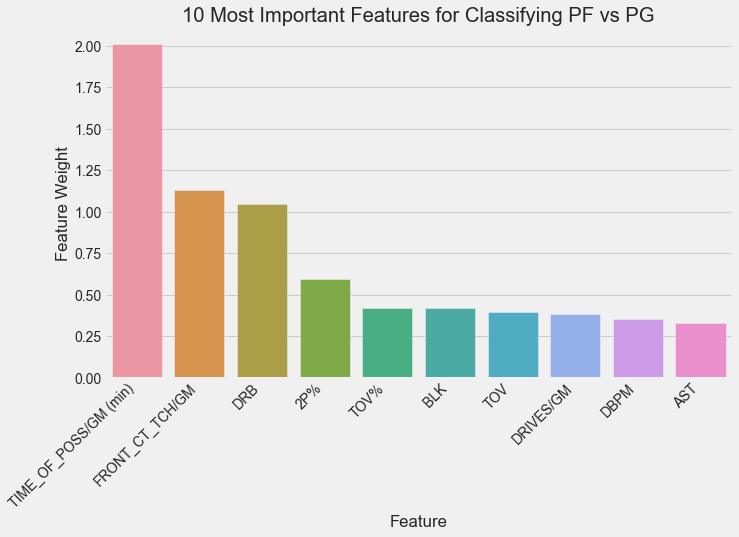

In [86]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in PF_vs_PG_sorted[:10]],
            y=[abs(i[1]) for i in PF_vs_PG_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying PF vs PG')
plt.xticks(rotation=45, horizontalalignment='right');

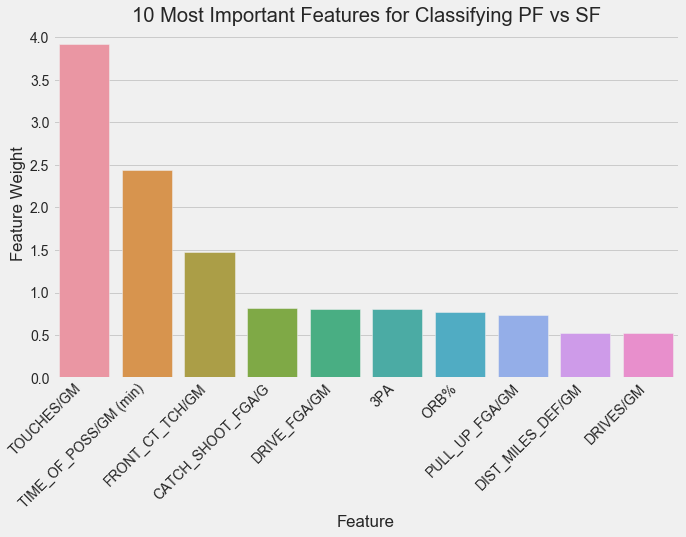

In [87]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in PF_vs_SF_sorted[:10]],
            y=[abs(i[1]) for i in PF_vs_SF_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying PF vs SF')
plt.xticks(rotation=45, horizontalalignment='right');

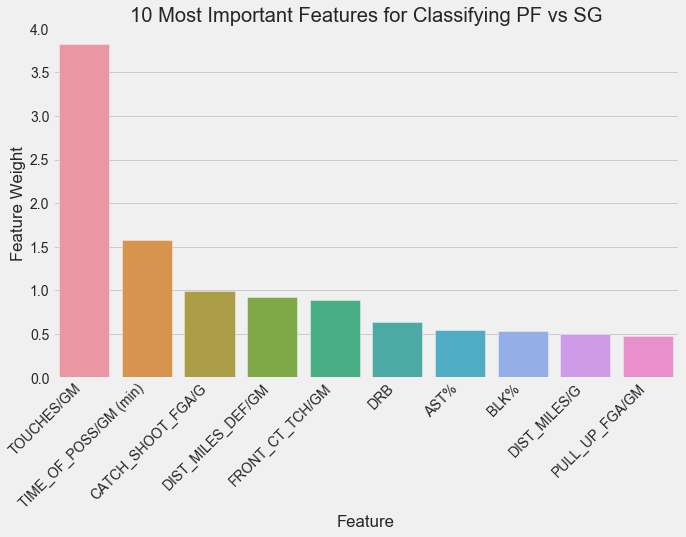

In [88]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in PF_vs_SG_sorted[:10]],
            y=[abs(i[1]) for i in PF_vs_SG_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying PF vs SG')
plt.xticks(rotation=45, horizontalalignment='right');

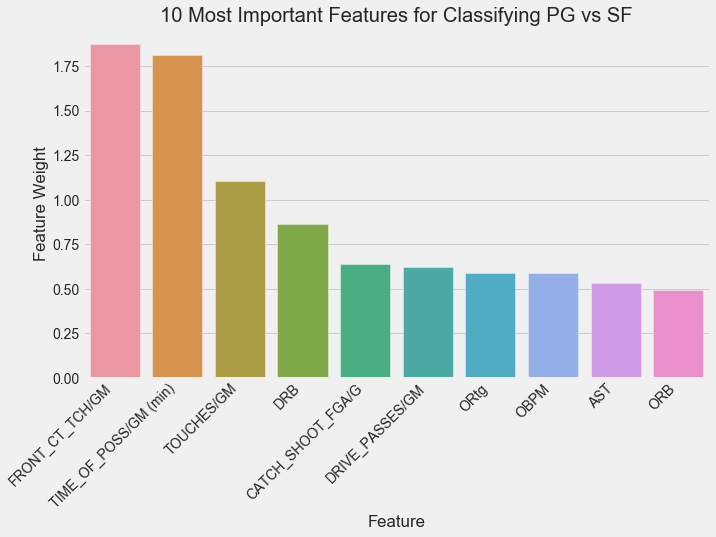

In [89]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in PG_vs_SF_sorted[:10]],
            y=[abs(i[1]) for i in PG_vs_SF_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying PG vs SF')
plt.xticks(rotation=45, horizontalalignment='right');

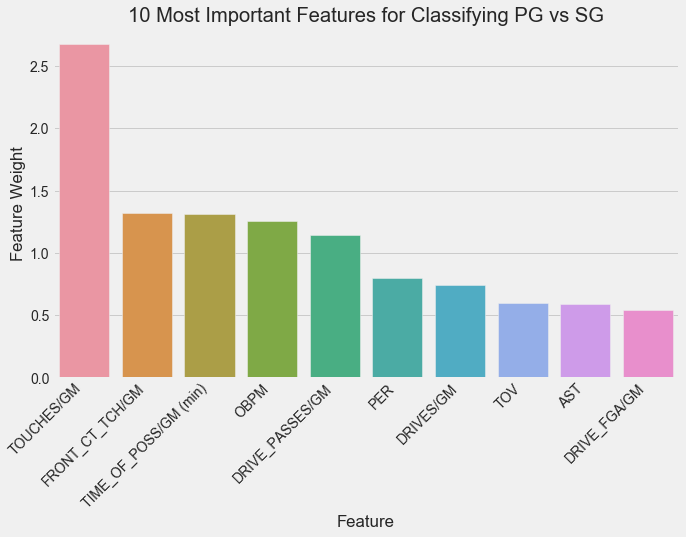

In [90]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in PG_vs_SG_sorted[:10]],
            y=[abs(i[1]) for i in PG_vs_SG_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying PG vs SG')
plt.xticks(rotation=45, horizontalalignment='right');

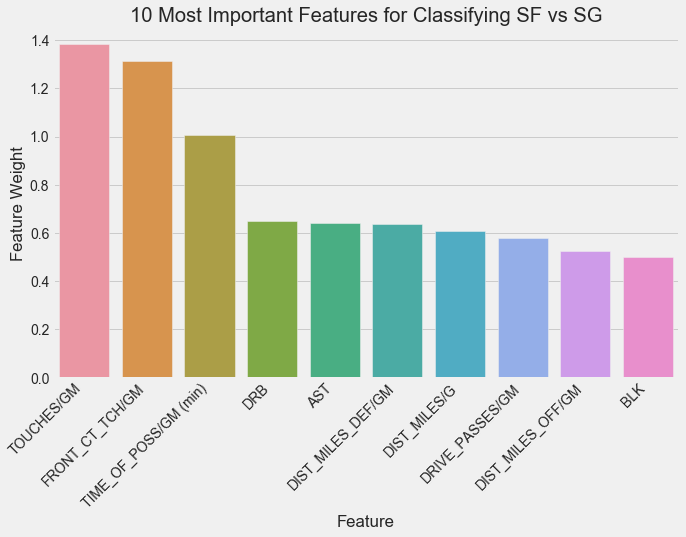

In [91]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6));
sns.barplot(x=[i[0] for i in SF_vs_SG_sorted[:10]],
            y=[abs(i[1]) for i in SF_vs_SG_sorted[:10]]);
plt.xlabel('Feature')
plt.ylabel('Feature Weight')
plt.title('10 Most Important Features for Classifying SF vs SG')
plt.xticks(rotation=45, horizontalalignment='right');

In [92]:
pred_test_proba = grid_svc_2.predict_proba(X_test_log)
pred_train_proba = grid_svc_2.predict_proba(X_train_log)

In [96]:
X_train_index = list(X_train_log.index.values) #store index values of X_train in a list for use in class
X_test_index = list(X_test_log.index.values) #store index values of X_test in a list for use in class

zipped_proba_train_index = list(zip(X_train_index, pred_train_proba)) #match indices with probabilities
zipped_proba_test_index = list(zip(X_test_index, pred_test_proba)) #match indices with probabilities

In [157]:
class Player:
    """A class used to identify an NBA Player as well, their official position,
    and provide probability estimates for which position they would play in a 
    basketball game.
    
    Attributes
    ----------
    first_name: The player's first name
    
    last_name: The player's last name
    
    year: The season in which a player participated. It should be formatted as a string.
    For example, year should be written as '15-16' which would represent the 2015-2016 season.
    
    player_postion: The player's position as listed on basketball-reference.com
    For reference C is center, PF is power forward, PG is point guard, SF is small forward and
    SG is shooting guard.
    
    player_ID: A combination of first name, last name, and year that is used to access
    statistical information from a dataframe.
    
    Methods
    ---------
    
    position_breakdown: This method returns a pie chart showing the probability that a player
    played at each position over the course of season denoted by the attribute year.
    """
    def __init__(self, first_name, last_name, year):
        """Initializes player attributes."""
        self.first_name = first_name
        self.last_name = last_name
        self.year = year
        self.player_ID = self.first_name + ' ' + self.last_name + ' ' + f'({self.year})'
        self.player_position = df_cutoff.loc[df_cutoff['PLAYER_NAME'] == self.player_ID, 'Pos']
    
    def position_breakdown(self):
        """Returns pie chart of positional probability for a player."""
        #Find index of row in dataframe corresponding to player name
        df_index_val = df_cutoff[df_cutoff['PLAYER_NAME'] == self.player_ID].index.tolist()
        
        #Find index in either X_test or X_train
        if df_index_val[0] in X_test_index:
            index_final = X_test_index.index(df_index_val[0])
            prob_vals = zipped_proba_test_index[index_final][1]
        else:
            index_final = X_train_index.index(df_index_val[0])
            prob_vals = zipped_proba_train_index[index_final][1]
        
        #Create pie chart 
        pie_fig = px.pie(names=['C', 'PF', 'PG', 'SF', 'SG'], values=prob_vals, 
             color_discrete_sequence=px.colors.qualitative.G10, title=self.player_ID)
        pie_fig.update_traces(textinfo='percent+label', textfont_size=16)
        
        return pie_fig
        
        
        
    
        

In [158]:
Lebron = Player('LeBron', 'James', '15-16')
Lebron.player_ID

'LeBron James (15-16)'

In [159]:
Lebron.player_position

220    SF
Name: Pos, dtype: object

In [160]:
Lebron.position_breakdown()

In [156]:
fig = px.pie(names=['C', 'PF', 'PG', 'SF', 'SG'], values=pred_train_proba[311], 
             color_discrete_sequence=px.colors.qualitative.G10)
fig.update_traces(textinfo='percent+label', textfont_size=16)

In [144]:
X_test_index[5]

962

In [150]:
X_train_index.index(220)

308